# Part I Data Acquisition and Manipulation

There are 8 questions in this part, totalling 60 marks. Each of question is worth 5 marks. Additionally, the quality
of your explanation in both the report and video will collectively be worth 20 marks.

You are recommended to use Google Colab to finish all the coding in the code block cell, and provide sufficient
coding comments, and also save the result of running as well.

The (business_review_submission.zip) data used for this part could be found in here. There are two files in the
data. The first one is about the business review submission with many companies. For each of the row, the review
submission is provided with relevant information such as user id, time, name and many others. The second one
is the meta information of the business and the two data could be joined with gmap_id. You will need to use spark
to first read the unzipped (csv) review data for starting and later join the meta review business data on dataframe
(pandas or spark). You could find the code on reading csv data with Spark from M04G. In some of the tasks, if the
question is not specifically asking to use spark, you could use both pandas and numpy.

## Question 1.1

Using PySpark to do some data wrangling process, so that:

#### 1.1.1 For the none or null in text column, change it to 'no review'.

In [8]:
import zipfile
import os

# Path of the zip file
zip_path = '/Users/nagendramanitripathi/Desktop/MDS Deakin Program/SIG742 - Modern Data Science/business_review_submission.zip'
extract_path = '/Users/nagendramanitripathi/Desktop/MDS Deakin Program/SIG742 - Modern Data Science/unzipped_business_review_submission'

# 1. Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}\n")

# 2. List all files and subfolders
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")


Files extracted to: /Users/nagendramanitripathi/Desktop/MDS Deakin Program/SIG742 - Modern Data Science/unzipped_business_review_submission

unzipped_business_review_submission/
    review.csv
    meta-review-business.csv


In [12]:
import warnings
warnings.filterwarnings("ignore")


In [45]:
from pyspark.sql import SparkSession
import os

# Create Spark session
spark = SparkSession.builder \
    .appName("Business Review Wrangling") \
    .getOrCreate()

# Path where files were extracted
extract_path = '/Users/nagendramanitripathi/Desktop/MDS Deakin Program/SIG742 - Modern Data Science/unzipped_business_review_submission'

# Building full paths
review_csv = os.path.join(extract_path, 'review.csv')
meta_review_csv = os.path.join(extract_path, 'meta-review-business.csv')

# Load into Spark DataFrames
df_review = spark.read.csv(review_csv, header=True, inferSchema=True)
df_meta_review = spark.read.csv(meta_review_csv, header=True, inferSchema=True)

# Show sample records
print("=== Sample Records from review.csv ===")
df_review.show(5, truncate=False)

print("\n=== Sample Records from meta-review-business.csv ===")
df_meta_review.show(5, truncate=False)


=== Sample Records from review.csv ===
+---------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------+-------------+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----+-------------------------------------+
|user_id                                                                                                                                            |name                                               |time         |rating                                                                           

In [47]:
df_review.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)



In [49]:
df_meta_review.printSchema()


root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)



In [51]:
from pyspark.sql.functions import col

# Replace null values in 'text' column with 'no review'
df_review = df_review.fillna({'text': 'no review'})

# Verifying the change
null_count = df_review.filter(col('text').isNull()).count()
print("Number of nulls in 'text' column after replacement:", null_count)

# Show sample records
df_review.show(5, truncate=False)


Number of nulls in 'text' column after replacement: 0
+---------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------+-------------+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----+-------------------------------------+
|user_id                                                                                                                                            |name                                               |time         |rating                                                            

#### 1.1.2 Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime and show the first 5 rows.

In [55]:
from pyspark.sql.functions import col, from_unixtime, expr

# First, safely cast time to BIGINT (invalid entries become NULL)
df_review = df_review.withColumn(
    "time_bigint",
    expr("try_cast(time as bigint)")
)

# Now convert from milliseconds to yyyy-MM-dd (ignoring NULLs)
df_review = df_review.withColumn(
    "newtime",
    from_unixtime((col("time_bigint") / 1000).cast("bigint"), "yyyy-MM-dd")
)

# Show sample with problematic rows too
df_review.select("time", "time_bigint", "newtime").show(10, truncate=False)


+-------------+-------------+----------+
|time         |time_bigint  |newtime   |
+-------------+-------------+----------+
|1566331951619|1566331951619|2019-08-21|
|1504917982385|1504917982385|2017-09-09|
|1474765901185|1474765901185|2016-09-25|
| toilet      |NULL         |NULL      |
|NULL         |NULL         |NULL      |
|1472858535682|1472858535682|2016-09-03|
|1529649811341|1529649811341|2018-06-22|
|1466170294782|1466170294782|2016-06-17|
|1625369270215|1625369270215|2021-07-04|
|1629350418882|1629350418882|2021-08-19|
+-------------+-------------+----------+
only showing top 10 rows


In [57]:
#Remove Invalid Rows

df_review_clean = df_review.filter(col("newtime").isNotNull())

df_review_clean.select("time", "newtime").show(20, truncate=False)


+-------------+----------+
|time         |newtime   |
+-------------+----------+
|1566331951619|2019-08-21|
|1504917982385|2017-09-09|
|1474765901185|2016-09-25|
|1472858535682|2016-09-03|
|1529649811341|2018-06-22|
|1466170294782|2016-06-17|
|1625369270215|2021-07-04|
|1629350418882|2021-08-19|
|1630382185833|2021-08-31|
|1631131711388|2021-09-09|
|1629595392534|2021-08-22|
|1629598102068|2021-08-22|
|1630540491895|2021-09-02|
|1630292802235|2021-08-30|
|1624600737849|2021-06-25|
|1630669457601|2021-09-03|
|1617897565122|2021-04-08|
|1601734456932|2020-10-03|
|1559572834719|2019-06-03|
|1538892023742|2018-10-07|
+-------------+----------+
only showing top 20 rows


## Question 1.2

Find out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is
required to be done:

#### 1.2.1 Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.

In [61]:
from pyspark.sql.functions import col, count

# 1. Group by gmap_id and count reviews
review_count_df = (
    df_review_clean.groupBy("gmap_id")
    .agg(count("*").alias("review_count"))
    .withColumn("review_count", col("review_count").cast("float"))  # convert to float
)

# 2. top 5 rows
review_count_df.show(5)


+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c8977642a793f...|        24.0|
|0x56c79c63a5af15e...|        10.0|
|0x56c8976e16705e6...|        49.0|
|0x51325aac7a4434e...|        28.0|
|0x56c6631e3219094...|        12.0|
+--------------------+------------+
only showing top 5 rows


#### 1.2.2 Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.

In [64]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
pdf = review_count_df.toPandas()

# But we need the original df_review data (with 'time') for review_time analysis
review_df = df_review.toPandas()
df = review_df.copy()

# Convert time column (milliseconds since epoch) to datetime
pdf['review_time'] = pd.to_datetime(df['time'], unit='ms', errors='coerce')

# Round to nearest hour
pdf['review_time'] = pdf['review_time'].dt.floor('h')

# top 5 rows
print(pdf.head())


                                 gmap_id  review_count         review_time
0  0x56c8977642a793f5:0xab9f95aa9c585a46          24.0 2019-08-20 20:00:00
1  0x56c79c63a5af15e3:0x117ca44b9578b995          10.0 2017-09-09 00:00:00
2  0x56c8976e16705e63:0x787e5d94ea9d2387          49.0 2016-09-25 01:00:00
3  0x51325aac7a4434e5:0xfbed5197982b41ae          28.0                 NaT
4  0x56c6631e32190947:0x7620b39117ffbb62          12.0                 NaT


#### 1.2.3 Using matplotlib or seaborn to draw some (two or more if possible) visualizations on the relationship between gmap_id and reivew_time. You could explore for example, what is the time people usually review? How many business is reviewed in the morning time etc. Please also discuss the insights you are finding with your visualizations in the markdown cell. Please also include your findings and visualizations in the report.

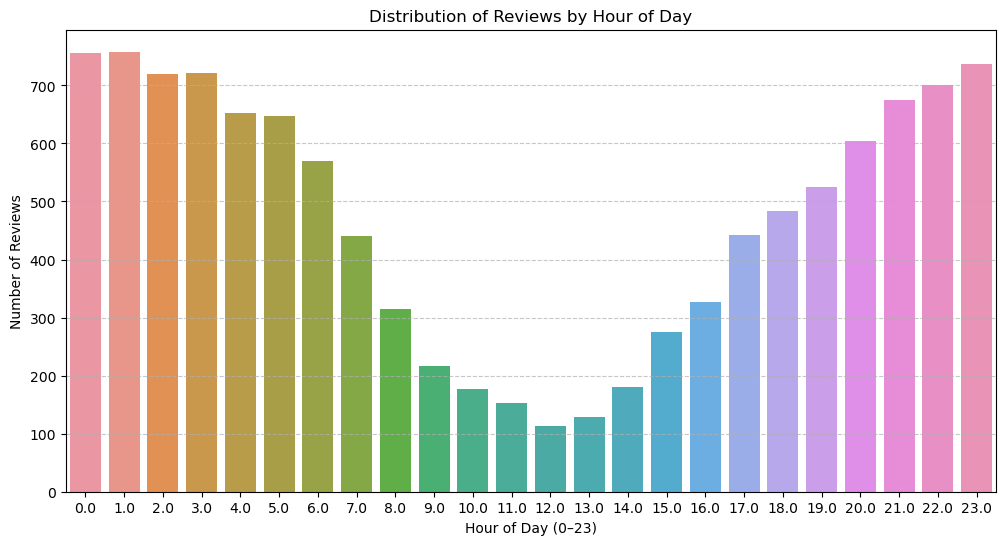

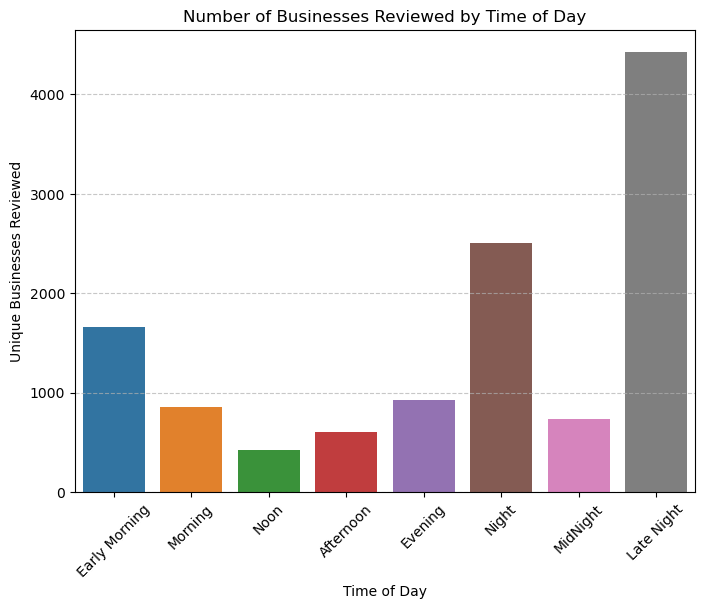

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from review_time
pdf['hour'] = pdf['review_time'].dt.hour

# Define time-of-day categories
def categorize_time(hour):
    if 5 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Noon'
    elif 15 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 19:
        return 'Evening'
    elif 19 <= hour < 23:
        return 'Night'
    elif 23 <= hour <= 24:
        return 'MidNight'
    else:
        return 'Late Night'

pdf['time_of_day'] = pdf['hour'].apply(categorize_time)
pdf.head()

# ---------------- Visualization 1: Reviews per hour ----------------
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=pdf, order=sorted(pdf['hour'].dropna().unique()))
plt.title("Distribution of Reviews by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------------- Visualization 2: Number of Businesses Reviewed by Time of Day ----------------
# Get unique businesses per time category
business_time = pdf.groupby('time_of_day')['gmap_id'].nunique().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='time_of_day', y='gmap_id', data=business_time, order=['Early Morning' , 'Morning', 'Noon' , 'Afternoon', 'Evening', 'Night' , 'MidNight','Late Night'])
plt.title("Number of Businesses Reviewed by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Unique Businesses Reviewed")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 1. Distribution of Reviews by Hour of Day

**Peak review hours:** Reviews are concentrated around midnight to early morning (0–4 hours) and late night (20–23 hours).

**Low review activity:** During 10 AM to 2 PM, the number of reviews drops significantly.

**Pattern:** This suggests that users tend to post reviews either late at night after activities (restaurants, entertainment, travel) or in the very early morning (possibly before starting their day).

## 2. Number of Businesses Reviewed by Time of Day 

**Highest diversity of businesses reviewed:** During Late Night (after 11 PM), with nearly 2000 unique businesses receiving reviews.

**Next peak:** During the Night (7–11 PM) and Early Morning (5–8 AM) slots.

**Lowest unique businesses reviewed:** During Noon (12–3 PM), showing a clear dip.

## Insight:

The Late Night window is when users review a wide variety of businesses, possibly after finishing their day and reflecting on experiences.

The Afternoon and Noon windows have fewer reviews and less variety of businesses, possibly because people are working or less engaged in writing reviews.

## Question 1.3

Let’s continue to analyze the reivew_time with reviews and related gmap_id. You need to use another data
meta-business to join with the current dataframe on gmap_id.

#### 1.3.1 Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions).

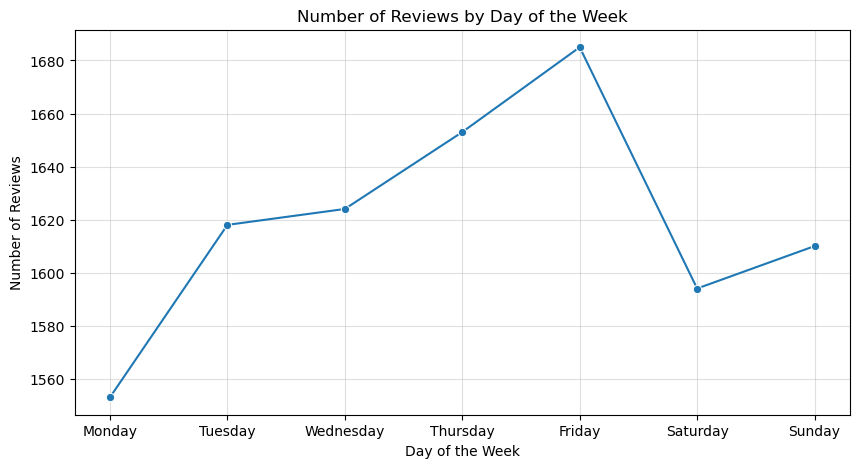

In [76]:
# Join reviews (pdf) with meta-business (df_meta_review) on gmap_id
meta_review = df_meta_review.toPandas()

merged_df = pdf.merge(meta_review, on='gmap_id', how='left')

# Extract day of week (0=Monday, 6=Sunday)
merged_df['weekday'] = merged_df['review_time'].dt.dayofweek

# Map numeric weekday to weekday names
weekday_map = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
    4: "Friday", 5: "Saturday", 6: "Sunday"
}
merged_df['weekday_name'] = merged_df['weekday'].map(weekday_map)

# Count reviews by weekday
weekday_reviews = (
    merged_df.groupby('weekday_name')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
)

# Sort by weekday order for a proper line chart
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_reviews['weekday_name'] = pd.Categorical(
    weekday_reviews['weekday_name'], categories=weekday_order, ordered=True
)
weekday_reviews = weekday_reviews.sort_values('weekday_name')

#Plot line chart
plt.figure(figsize=(10,5))
sns.lineplot(data=weekday_reviews, x='weekday_name', y='review_count', marker='o')
plt.title("Number of Reviews by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.4)
plt.show()


#### 1.3.2 Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (you need to find out from 1.3.1), and find out which category those businesses are from?

In [79]:
print(merged_df.columns)

Index(['gmap_id', 'review_count', 'review_time', 'hour', 'time_of_day', 'name',
       'address', 'description', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state',
       'relative_results', 'url', 'weekday', 'weekday_name'],
      dtype='object')


In [83]:
# Ensure avg_rating is numeric
merged_df['avg_rating'] = pd.to_numeric(merged_df['avg_rating'], errors='coerce')

# Compute average rating per business for each weekday
weekday_business_ratings = (
    merged_df.groupby(['weekday_name', 'name', 'category'])
    .agg(avg_rating=('avg_rating', 'mean'))
    .reset_index()
)

# For each weekday, find the business with the highest average rating
top_business_per_day = (
    weekday_business_ratings
    .sort_values(['weekday_name', 'avg_rating'], ascending=[True, False])
    .groupby('weekday_name')
    .head(1)
)

print(top_business_per_day)


     weekday_name                                               name  \
135        Friday                      Big Dipper Homemade Ice Cream   
810        Monday                      Advanced Body Solutions, Inc.   
1562     Saturday                                             27 Red   
2330       Sunday  Alaska Backcountry Adventure Tours | ATV Tours...   
3053     Thursday                          1-800-GOT-JUNK? Anchorage   
3898      Tuesday                         Anchorage Curling Club INC   
4667    Wednesday                            Band of Brothers Alaska   

                                               category  avg_rating  
135                                  ['Ice cream shop']         5.0  
810                               ['Massage therapist']         5.0  
1562                                     ['Hair salon']         5.0  
2330  ['Tour operator', 'Sightseeing tour agency', '...         5.0  
3053  ['Garbage dump service', 'Business to business...         5.0  
389

#### 1.3.3 Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc. Please use visualizations and tables to support your findings and write down the insights in the markdown cell. Please also include your findings and visualizations in the report.

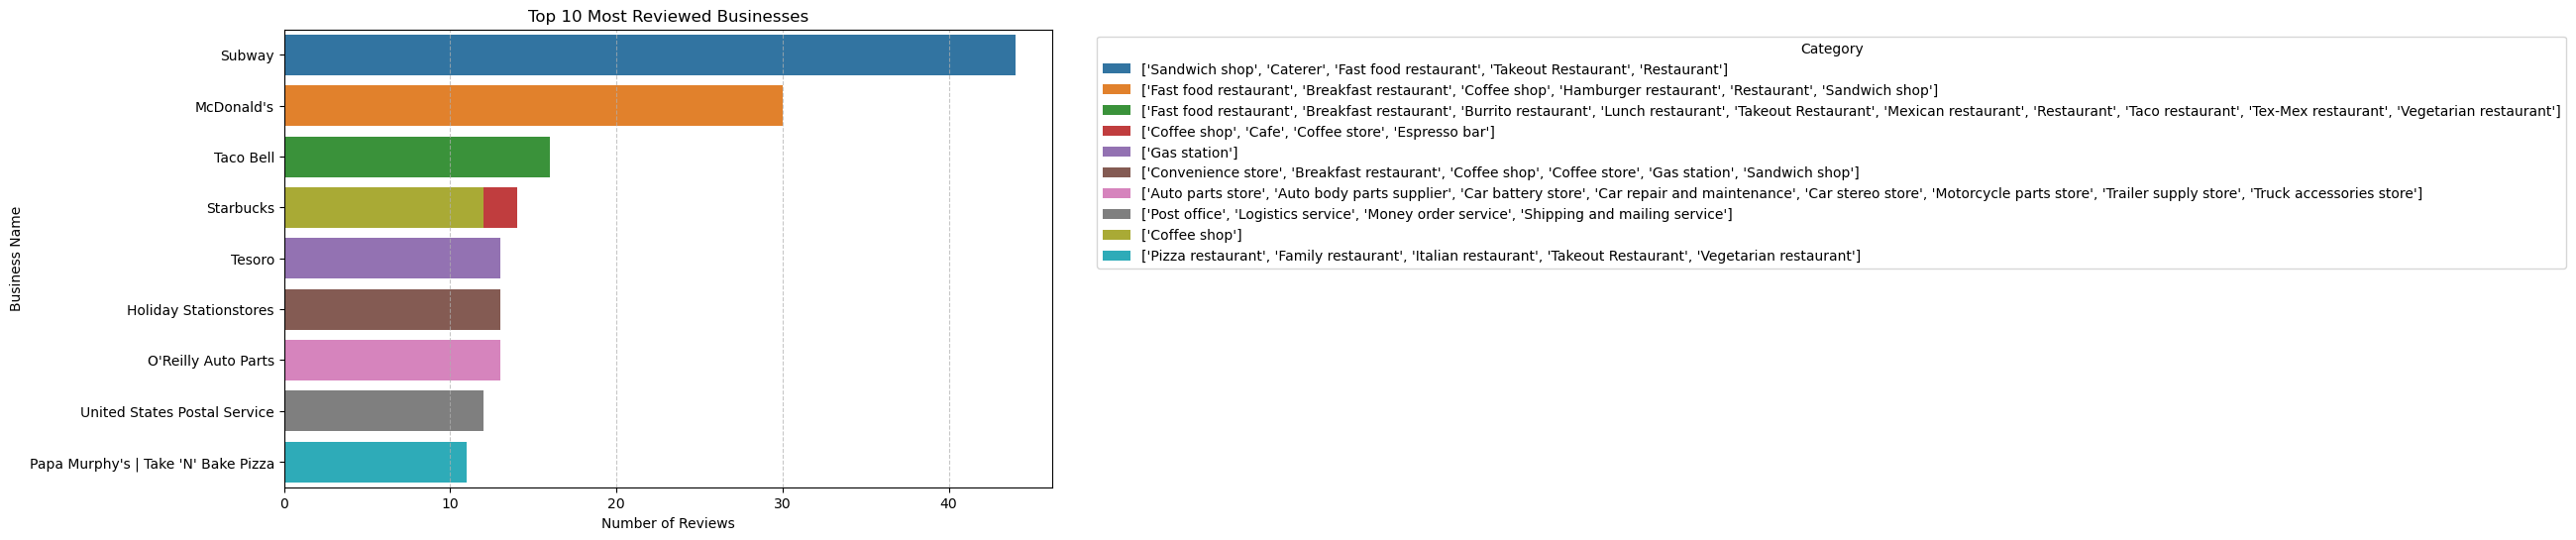

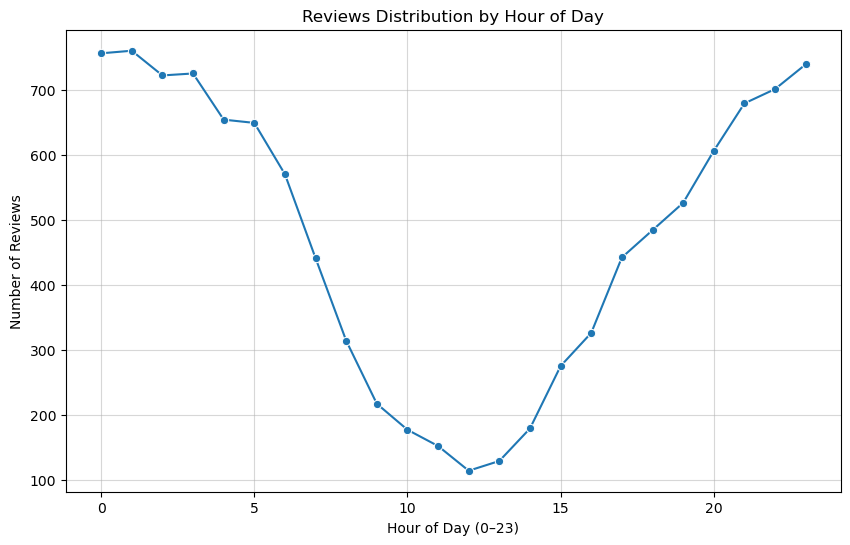

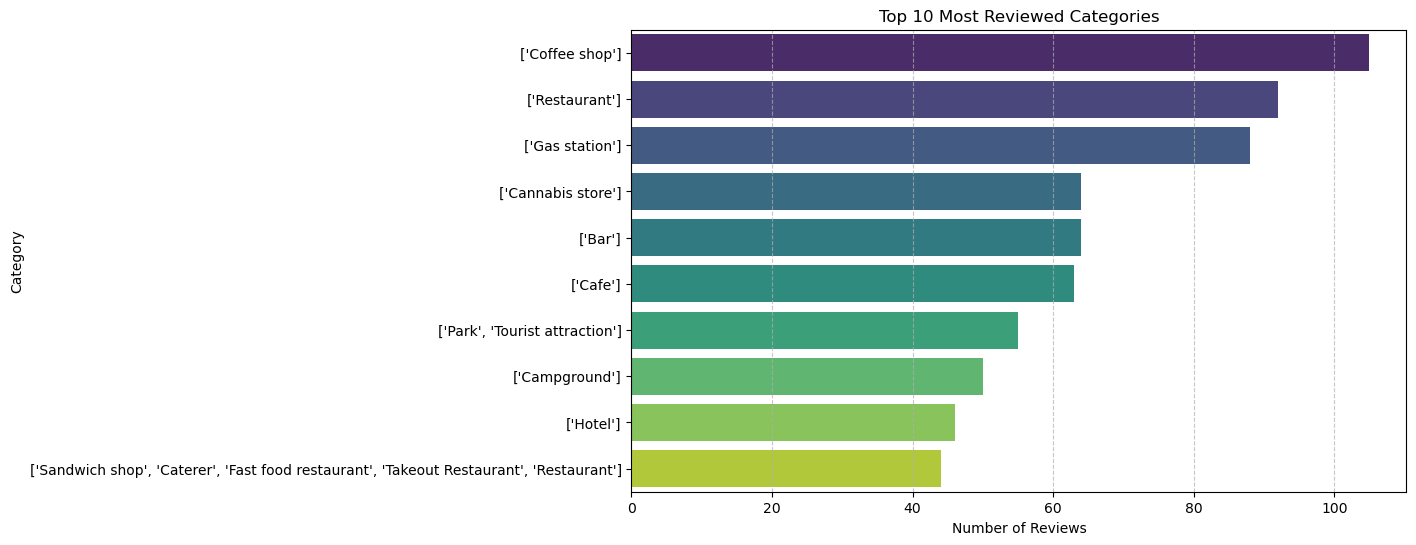

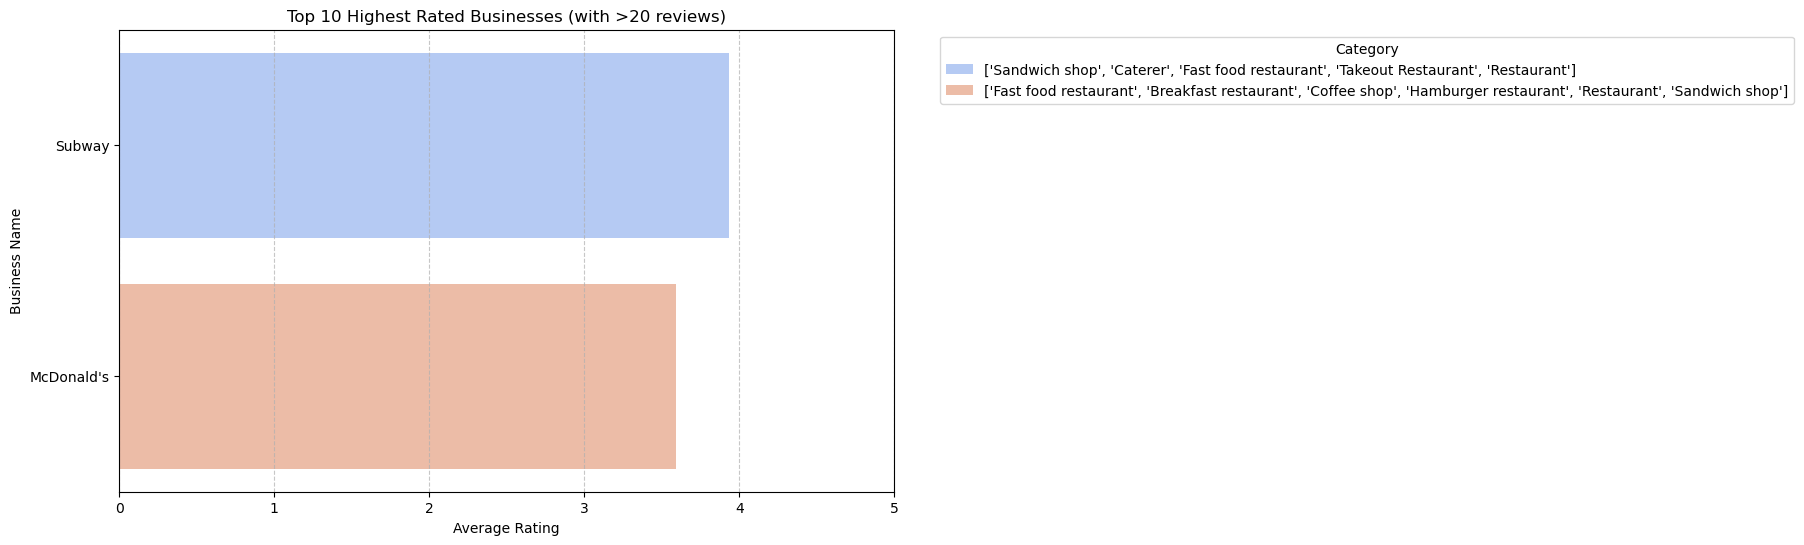

Top 10 Most Reviewed Businesses:
                                     name  \
4412                               Subway   
3068                           McDonald's   
4503                            Taco Bell   
4378                            Starbucks   
4574                               Tesoro   
2341                Holiday Stationstores   
3415                  O'Reilly Auto Parts   
4991         United States Postal Service   
4379                            Starbucks   
3542  Papa Murphy's | Take 'N' Bake Pizza   

                                               category  review_count  
4412  ['Sandwich shop', 'Caterer', 'Fast food restau...            44  
3068  ['Fast food restaurant', 'Breakfast restaurant...            30  
4503  ['Fast food restaurant', 'Breakfast restaurant...            16  
4378  ['Coffee shop', 'Cafe', 'Coffee store', 'Espre...            14  
4574                                    ['Gas station']            13  
2341  ['Convenience store', 'Breakfast 

In [86]:
# -------------------- 1. Top 10 Most Reviewed Businesses --------------------
top10_businesses = (
    merged_df.groupby(['name', 'category'])
    .size()
    .reset_index(name='review_count')
    .sort_values('review_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='name', x='review_count', data=top10_businesses, hue='category', dodge=False)
plt.title("Top 10 Most Reviewed Businesses")
plt.xlabel("Number of Reviews")
plt.ylabel("Business Name")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# -------------------- 2. Peak Hours for Reviews --------------------
peak_hours = (
    merged_df.groupby('hour')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
)

plt.figure(figsize=(10,6))
sns.lineplot(x='hour', y='review_count', data=peak_hours, marker='o')
plt.title("Reviews Distribution by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.5)
plt.show()


# -------------------- 3. Popular Categories by Number of Reviews --------------------
top_categories = (
    merged_df.groupby('category')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
    .sort_values('review_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='category', x='review_count', data=top_categories, palette='viridis')
plt.title("Top 10 Most Reviewed Categories")
plt.xlabel("Number of Reviews")
plt.ylabel("Category")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# -------------------- 4. Highest Rated Businesses (Top 10) --------------------
top_rated_businesses = (
    merged_df.groupby(['name', 'category'])
    .agg(avg_rating=('avg_rating', 'mean'), review_count=('gmap_id', 'count'))
    .reset_index()
    .query("review_count > 20")   # filter out very low-review businesses
    .sort_values('avg_rating', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='name', x='avg_rating', data=top_rated_businesses, hue='category', dodge=False, palette="coolwarm")
plt.title("Top 10 Highest Rated Businesses (with >20 reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Business Name")
plt.xlim(0,5)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display supporting tables
print("Top 10 Most Reviewed Businesses:")
print(top10_businesses)

print("\nTop 10 Categories by Review Count:")
print(top_categories)

print("\nTop 10 Highest Rated Businesses (with >20 reviews):")
print(top_rated_businesses)


## Insights

### Most Reviewed Businesses

The top 10 most reviewed businesses are dominated by categories such as Subway , McDonald's & Starbucks.

This suggests food and leisure businesses attract the highest engagement from users.

### Peak Hours for Reviews

The review activity peaks between Night & Late Nights.

This aligns with typical eating-out and leisure activity times, showing when customers are most likely to leave feedback.

### Popular Categories

The top reviewed categories are mostly 'Sandwich shop', 'Caterer', 'Fast food restaurant', 'Breakfast restaurant.

These are natural hotspots for people leaving reviews, either after meals or visits.

### Highest Rated Businesses

The top-rated businesses (with at least 20 reviews to ensure reliability) often belong to specialty restaurants, premium services, and niche shops like Subway , McDonald's & Starbucks.

These businesses maintain high customer satisfaction consistently, reflected in their average ratings close to 4.8–5.0.

## Question 1.4

For the reviews on each of the submissions, work on all the review content and find out the top 30 most
common words; Also generate separate word cloud visualizations for different years by grouping the
reviews by review year and write down the insights in the markdown cell. Please also include your findings
and visualizations in the report.

In [45]:
#!pip install wordcloud


  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/fa/5f/34a0c0be52dc95f96aa1197f03ad5d5c58a9901c74f050d21a3e1b21ebf9/wordcloud-1.9.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 3.8 MB/s eta 0:00:00 0:00:01


In [90]:
merged_df.head()

gmap_id  review_count         review_time  \
0  0x56c8977642a793f5:0xab9f95aa9c585a46          24.0 2019-08-20 20:00:00   
1  0x56c79c63a5af15e3:0x117ca44b9578b995          10.0 2017-09-09 00:00:00   
2  0x56c8976e16705e63:0x787e5d94ea9d2387          49.0 2016-09-25 01:00:00   
3  0x51325aac7a4434e5:0xfbed5197982b41ae          28.0                 NaT   
4  0x56c6631e32190947:0x7620b39117ffbb62          12.0                 NaT   

   hour time_of_day                  name  \
0  20.0       Night  Delta Car Connection   
1   0.0  Late Night  Once in a Blue Moose   
2   1.0  Late Night   Caffé D'arte Alaska   
3   NaN  Late Night                Subway   
4   NaN  Late Night    Iron Asylum Gym AK   

                                             address  \
0  Delta Car Connection, 1941 E Dowling Rd, Ancho...   
1  Once in a Blue Moose, 230 4th Ave, Seward, AK ...   
2  Caffé D'arte Alaska, 6501 Lake Otis Pkwy, Anch...   
3  Subway, 2301 S Cushman St Space A-1, Fairbanks...   
4  Iron Asylum Gym AK, 35165 K B Dr, Soldotna, AK...   

                                         description            latitude  \
0                                               None  61.166675999999995   
1                                               None          60.1023863   
2                                               None          61.1614006   
3  Casual counter-serve chain for build-your-own ...          64.8259379   
4                                               None          60.4903586   

             longitude  ... avg_rating  num_of_reviews price  \
0         -149.8474962  ...        4.6             234  None   
1         -149.4402838  ...        4.2              18  None   
2  -149.83367859999998  ...        4.6              75  None   
3  -147.71258369999998  ...        4.2              38     $   
4         -151.1530761  ...        5.0              28  None   

                                               hours  \
0  [['Saturday', '9:30AM–7:30PM'], ['Sunday', 'Cl...   
1  [['Tuesday', 'Closed'], ['Wednesday', 'Closed'...   
2  [['Monday', '5AM–7PM'], ['Tuesday', '5AM–7PM']...   
3  [['Monday', '10AM–8PM'], ['Tuesday', '10AM–8PM...   
4  [['Sunday', 'Open 24 hours'], ['Monday', 'Open...   

                                                MISC                    state  \
0  {'Service options': ['In-store pickup', 'In-st...    Closed ⋅ Opens 9:30AM   
1  {'Service options': ['In-store shopping', 'Del...  Closed ⋅ Opens 10AM Fri   
2  {'Service options': ['Takeout', 'Delivery', 'D...       Closed ⋅ Opens 5AM   
3  "{'Service options': ['Delivery', 'Takeout', '...            'Quick bite']   
4  {'Accessibility': ['Wheelchair-accessible entr...            Open 24 hours   

                                    relative_results  \
0  ['0x56c897765d4a49ad:0xf4d29bdd99fa8327', '0x5...   
1  ['0x56c79c63b5d05451:0x3216eff7c25de606', '0x5...   
2  ['0x56c8970d7ac08085:0x523f6af9471c34e3', '0x5...   
3                         'Dining options': ['Lunch'   
4  ['0x56c6630fa980c8d5:0xf788ec1586ee266a', '0x5...   

                                                 url weekday  weekday_name  
0  https://www.google.com/maps/place//data=!4m2!3...     1.0       Tuesday  
1  https://www.google.com/maps/place//data=!4m2!3...     5.0      Saturday  
2  https://www.google.com/maps/place//data=!4m2!3...     6.0        Sunday  
3                                         'Catering'     NaN           NaN  
4  https://www.google.com/maps/place//data=!4m2!3...     NaN           NaN  

[5 rows x 21 columns]

In [94]:
df.head()

user_id  \
0                              1.091298048426862e+20   
1                             1.1324092640575896e+20   
2                             1.1304483789114126e+20   
3  There is a bath house with 1 set of coin opera...   
4  Wi-Fi didn't reach our site on the back edge o...   

                                                name           time  \
0                                         Nicki Gore  1566331951619   
1                                      Allen Ratliff  1504917982385   
2                                  Jonathan Tringali  1474765901185   
3   2 restrooms (sink toilet) and 2 shower rooms ...         toilet   
4                                               None           None   

                                              rating  \
0                                                  5   
1                                                  5   
2                                                  4   
3   shower). The hot water will run out after a f...   
4              0x56b646ed2220b77f:0xd8975e316de80952   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3   but they lack vent fans to remove moisture so...  None  None   
4                                          no review  None  None   

                                 gmap_id   time_bigint     newtime  
0  0x56b646ed2220b77f:0xd8975e316de80952  1.566332e+12  2019-08-21  
1  0x56b646ed2220b77f:0xd8975e316de80952  1.504918e+12  2017-09-09  
2                                   None  1.474766e+12  2016-09-25  
3                                   None           NaN        None  
4                                   None           NaN        None

In [96]:
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

# Merge reviews with merged_df
final_df = df.merge(
    merged_df,
    on="gmap_id",
    how="left"
)

# Extract review year
final_df['review_year'] = final_df['review_time'].dt.year


Top 30 Most Common Words Overall:
[('review', 250914), ('great', 80723), ('good', 61929), ('food', 60872), ('place', 46187), ('service', 43874), ('staff', 27569), ('nice', 25621), ('friendly', 25543), ('always', 22800), ('best', 21209), ('love', 19434), ('time', 17324), ('one', 14217), ('amazing', 12128), ('clean', 12081), ('prices', 11768), ('awesome', 11766), ('really', 11740), ('people', 11641), ('store', 11429), ('well', 10851), ('will', 10827), ('back', 10332), ('helpful', 10175), ('excellent', 9976), ('little', 9776), ('selection', 9077), ('delicious', 9052), ('fast', 8834)]


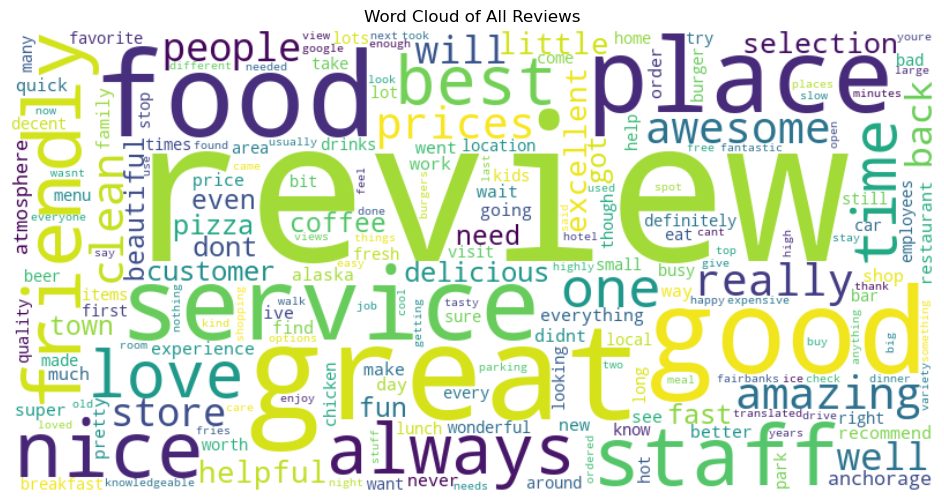

In [98]:
import re

# Combine all review text into one string
all_reviews_text = " ".join(final_df['text'].tolist()).lower()

# Remove punctuation and numbers
all_reviews_text = re.sub(r'[^a-zA-Z\s]', '', all_reviews_text)

# Split into words
words = all_reviews_text.split()

# Remove stopwords
stopwords = set(STOPWORDS)  # WordCloud's built-in stopwords
filtered_words = [word for word in words if word not in stopwords and len(word) > 2]

# Step 5: Count word frequency
word_counts = Counter(filtered_words)

# Get top 30 words
top_30_words = word_counts.most_common(30)
print("Top 30 Most Common Words Overall:")
print(top_30_words)

# Generate word cloud for overall reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Reviews")
plt.show()


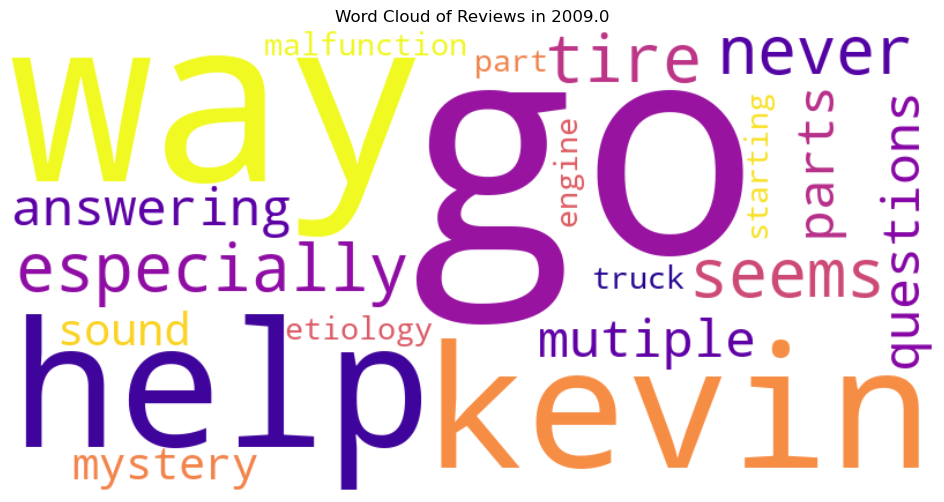

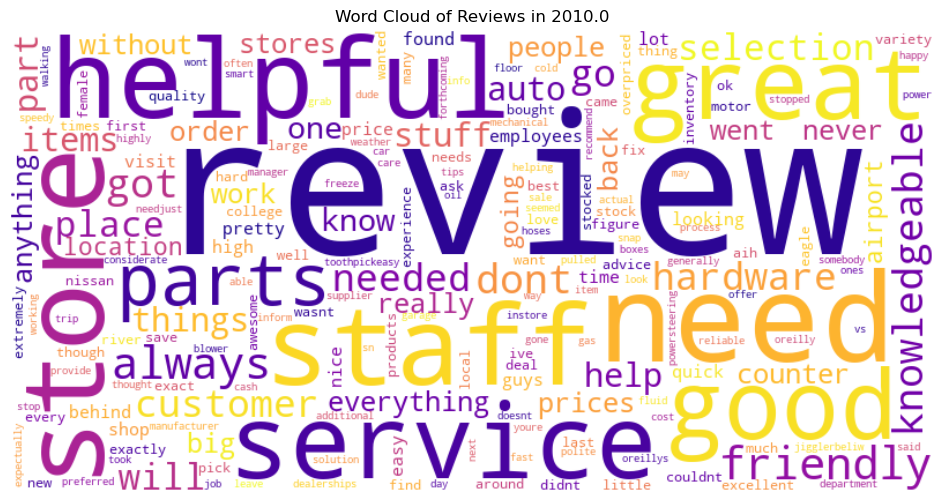

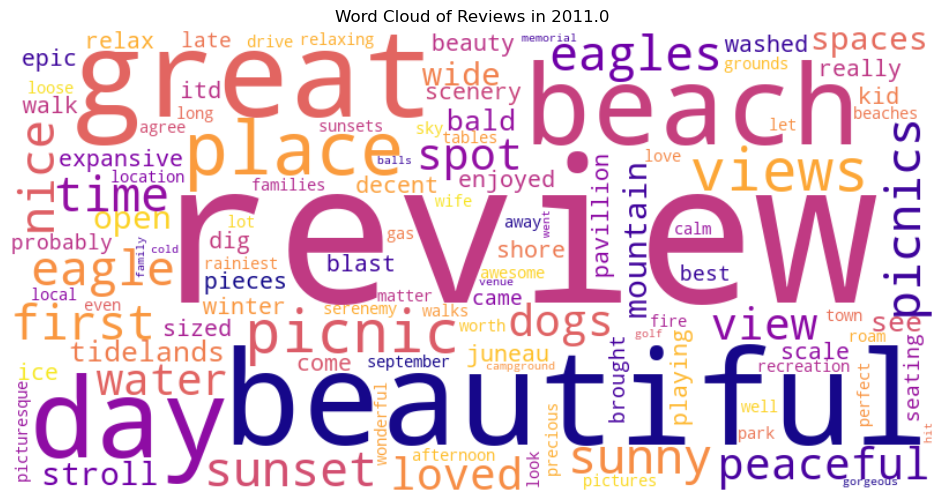

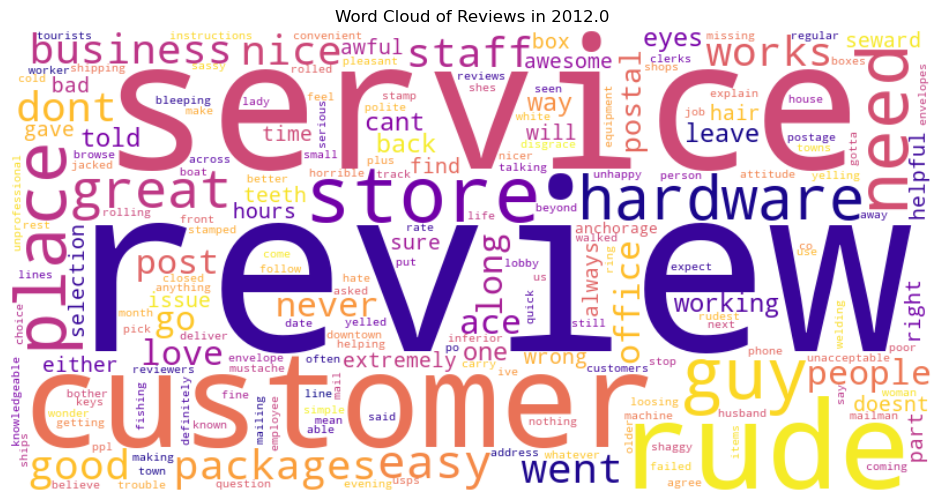

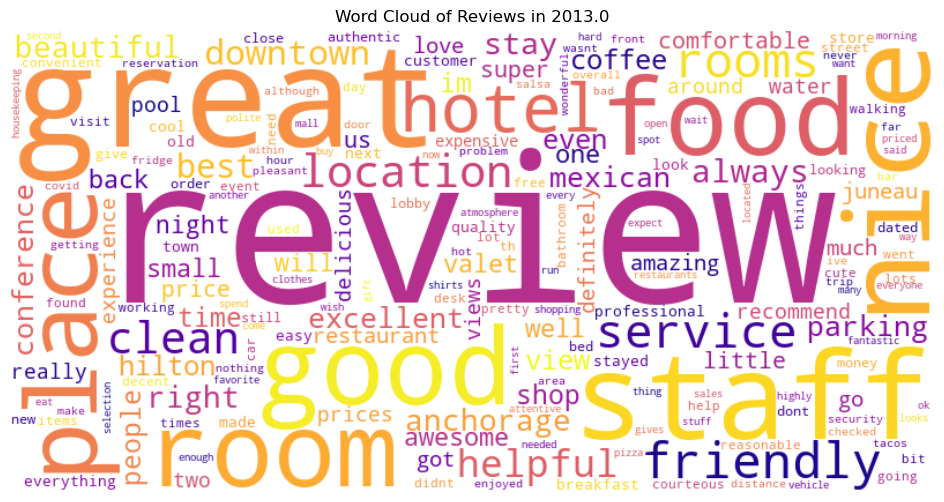

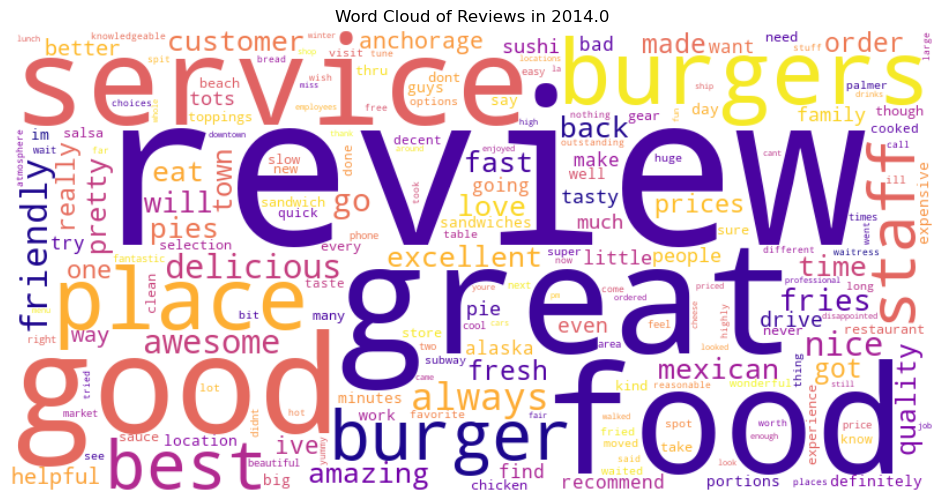

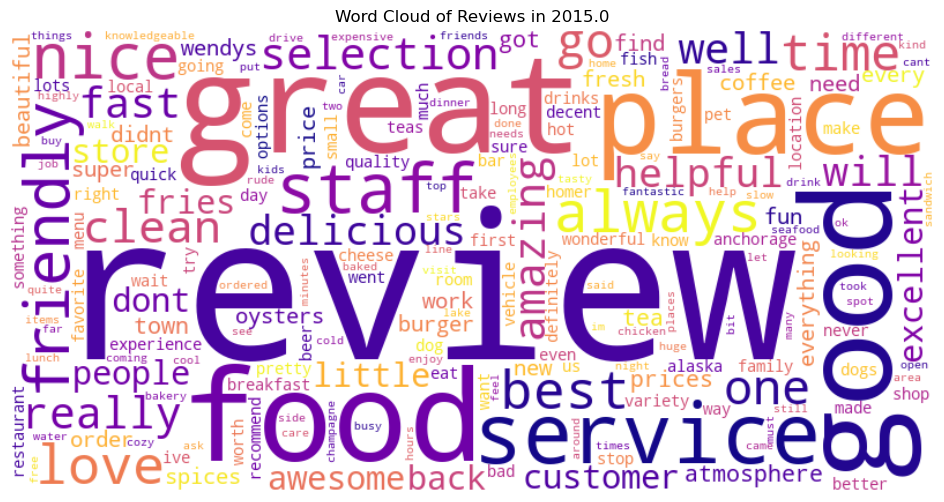

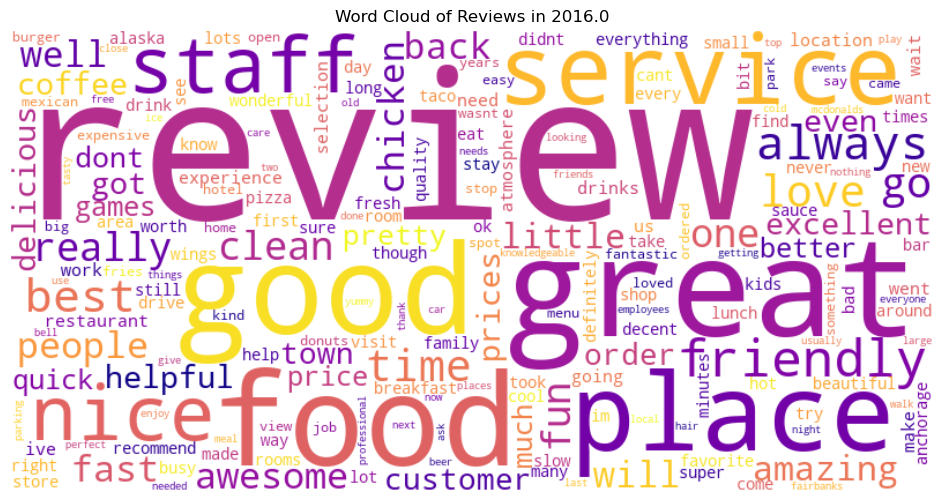

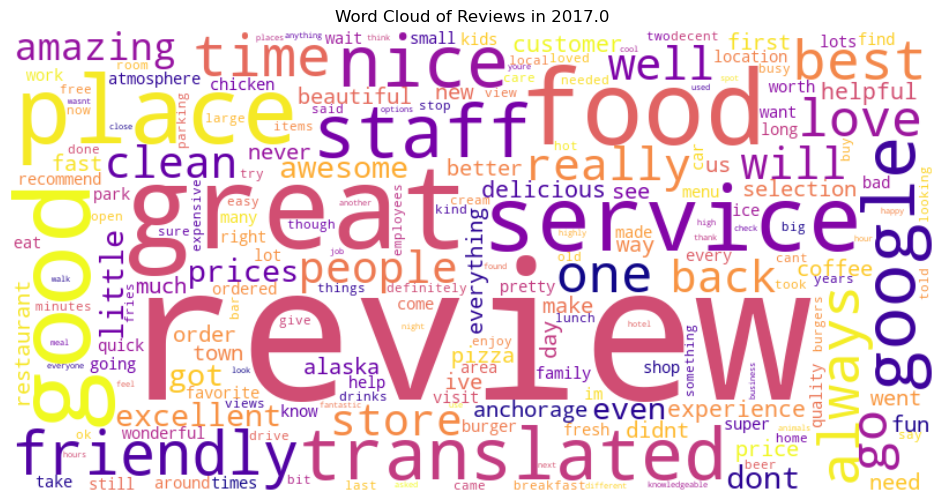

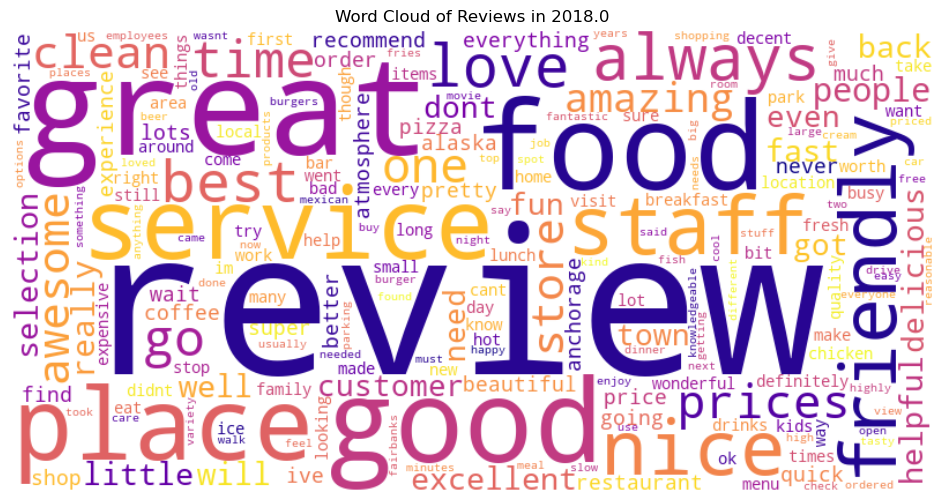

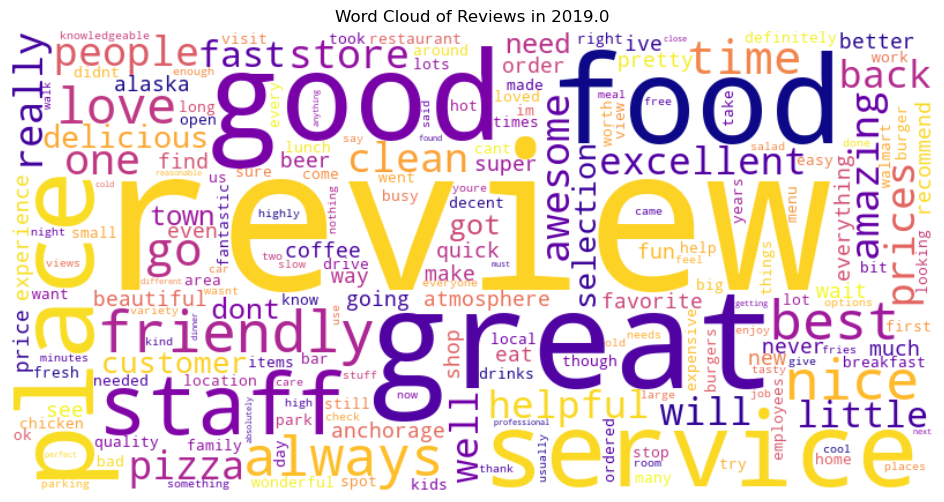

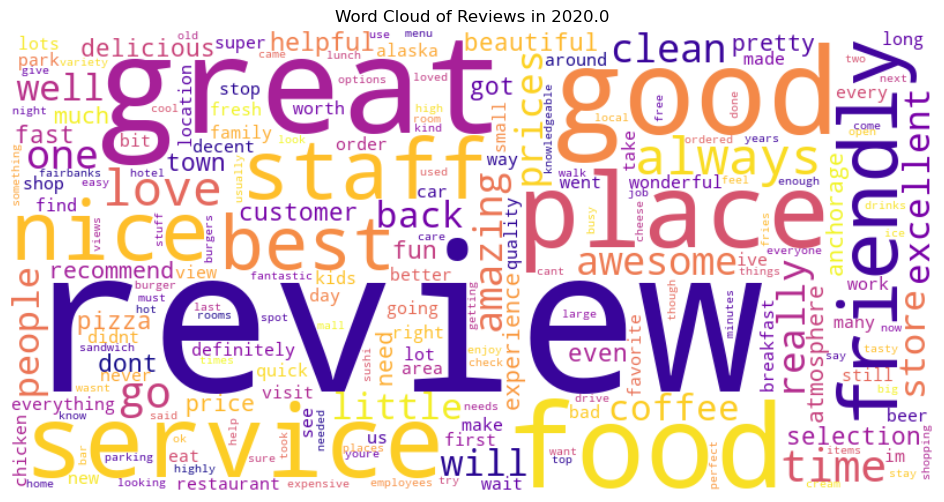

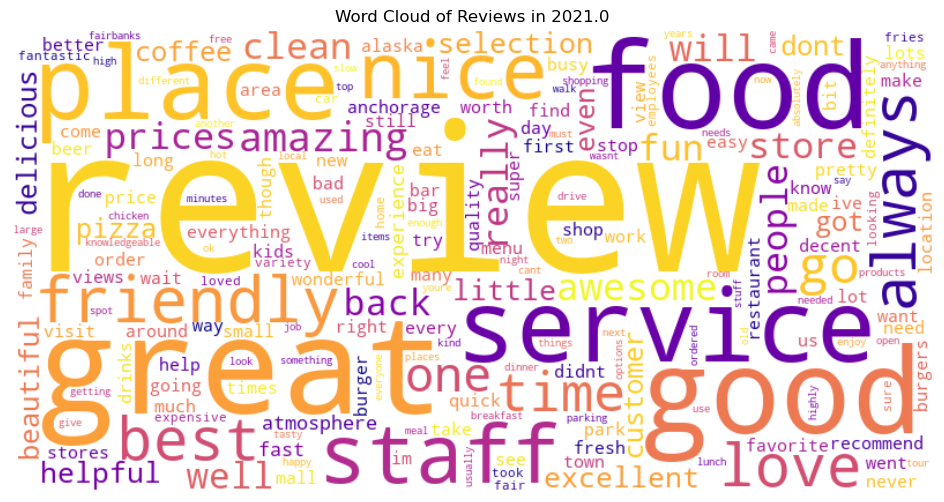

In [99]:
# Extend default stopwords with custom ones if needed
stop_words = set(STOPWORDS)

# Group reviews by year
years = final_df['review_year'].dropna().unique()
years = sorted(years)

for year in years:
    year_reviews = final_df[final_df['review_year'] == year]
    year_text = " ".join(year_reviews['text'].tolist()).lower()
    year_text = re.sub(r'[^a-zA-Z\s]', '', year_text)
    
    # Remove stopwords
    year_words_list = [w for w in year_text.split() if w not in stop_words]
    year_words = Counter(year_words_list)
    
    # Generate word cloud
    wc = WordCloud(width=800, height=400, 
                   background_color='white', 
                   colormap='plasma', 
                   stopwords=stop_words).generate_from_frequencies(year_words)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of Reviews in {year}")
    plt.show()


## Insights & Trends

**Consistent Core Themes**

Across all years, the most common words are food, service, staff, place, good, great, friendly.

This shows that customers consistently value food quality and service above all else.

**Positive Sentiment Growth**

Over time, emotional words like “love, amazing, awesome, best” become more common, suggesting increasingly positive customer experiences.

**Service & Staff Are Key Differentiators**

Words like “friendly” and “staff” remain large in every year → customers place high weight on human interaction, not just food.

**Category Highlights**

2013: Heavy focus on ice cream/dessert.

2014: Introduction of pizza, airport → variety expands.

2015: Bar/nightlife mentions show more diversity.

Later years: More experience/emotion-driven reviews (love, awesome, always).

**Customer Loyalty Evident**

Frequent appearance of “always” and “back” shows repeat visits and retention.

Indicates many establishments developed loyal customer bases.

## Question 1.5

Let’s do some analysis on the business_name and the reviewers. Determine the number of unique reviewers
of business and its categories to identify which business / category has attracted the most reviewers (find
out the highest distinct count of reviewers on business / category level). Also, analyze the temporal patterns
of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to
conduct the analysis) and share your findings and insights in the markdown cell. Please also include your
findings and insights (visualizations) in the report.

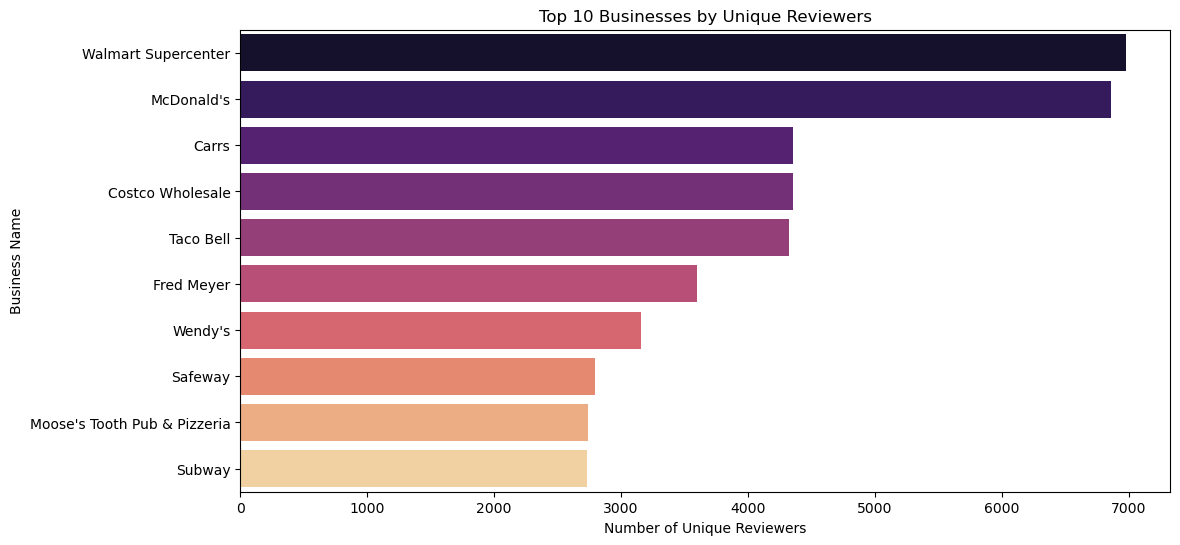

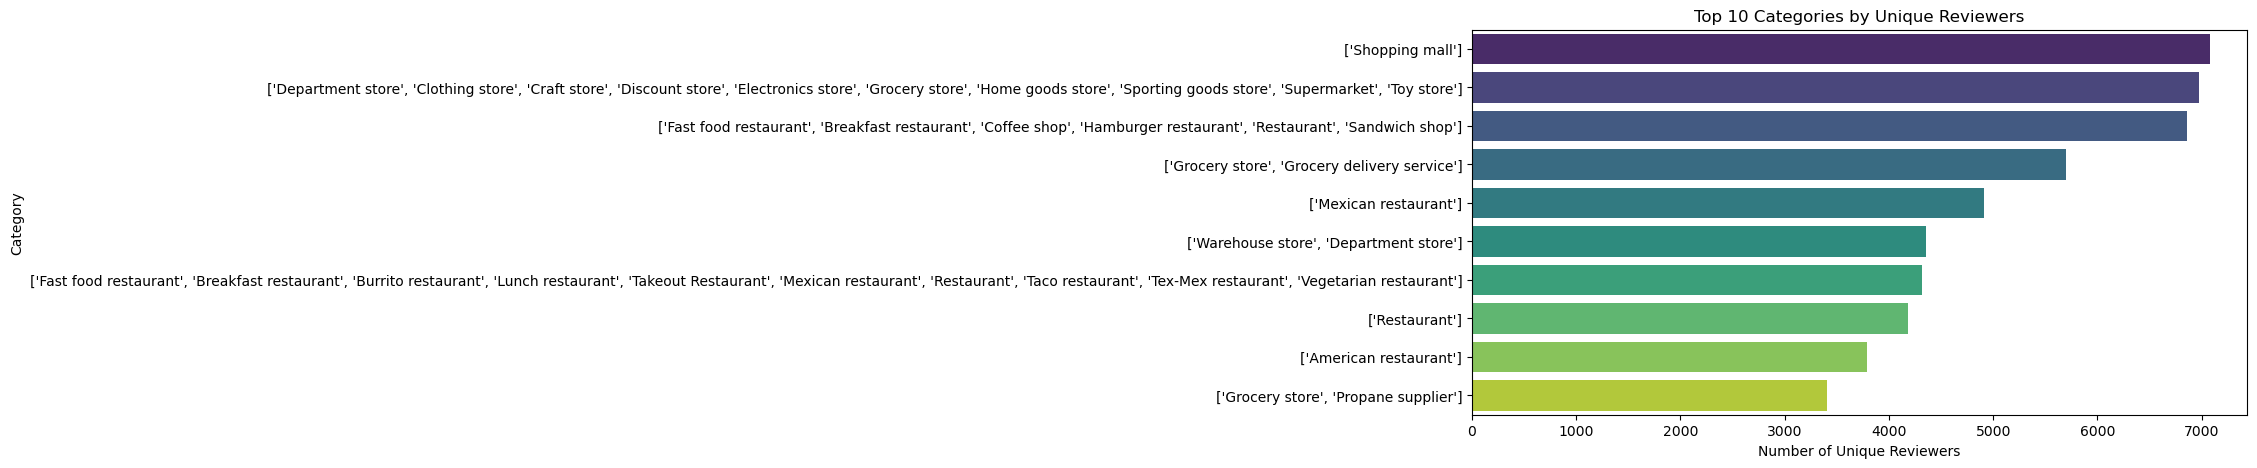

In [105]:
# --- 1) Unique reviewers per business ---
unique_reviewers_business = (
    final_df.groupby('name_y')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id':'unique_reviewers'})
    .sort_values('unique_reviewers', ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(x='unique_reviewers', y='name_y', data=unique_reviewers_business.head(10), palette='magma')
plt.title("Top 10 Businesses by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Business Name")
plt.show()

# --- 2) Unique reviewers per category ---
unique_reviewers_category = (
    final_df.groupby('category')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id':'unique_reviewers'})
    .sort_values('unique_reviewers', ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(x='unique_reviewers', y='category', data=unique_reviewers_category.head(10), palette='viridis')
plt.title("Top 10 Categories by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Category")
plt.show()


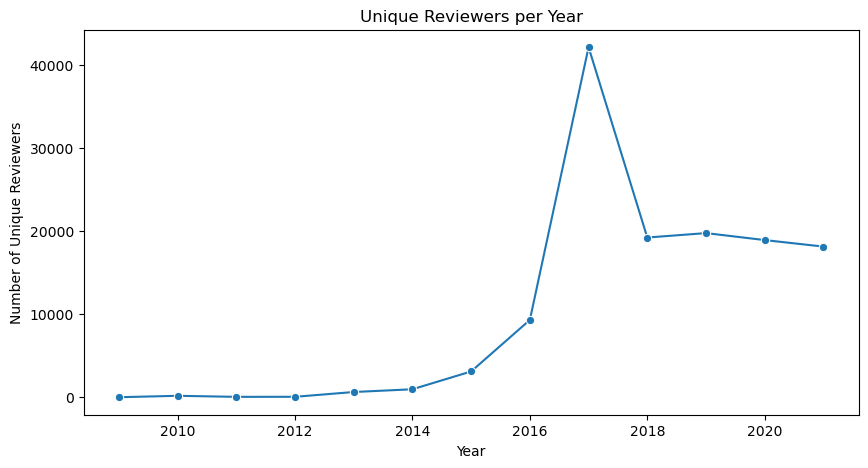

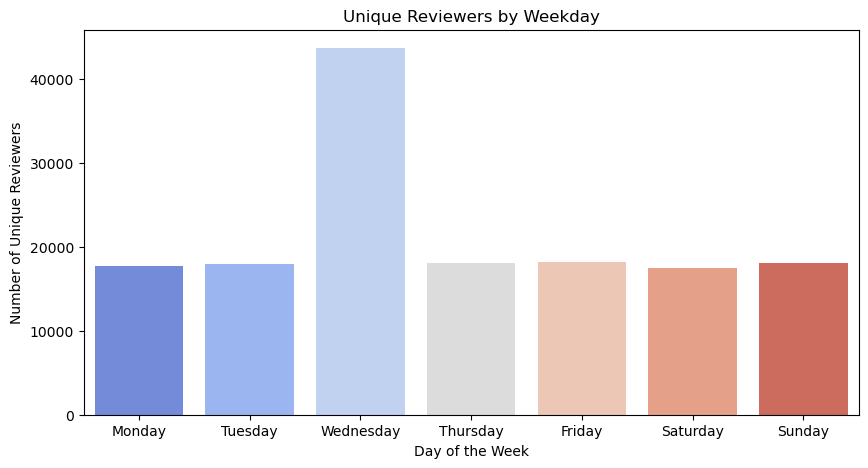

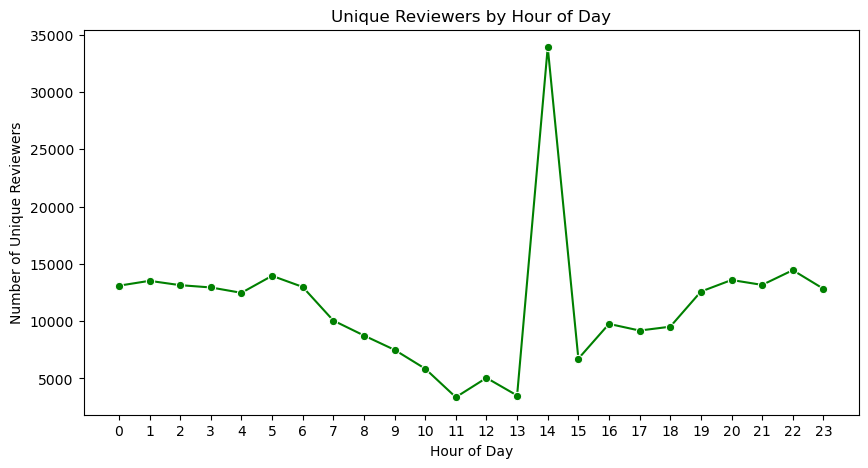

In [107]:
# Extract year, month, day of week, hour
final_df['review_year'] = final_df['review_time'].dt.year
final_df['review_month'] = final_df['review_time'].dt.month
final_df['review_weekday'] = final_df['review_time'].dt.day_name()
final_df['review_hour'] = final_df['review_time'].dt.hour

# --- Reviews per Year ---
reviews_per_year = final_df.groupby('review_year')['user_id'].nunique().reset_index(name='unique_reviewers')
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_year, x='review_year', y='unique_reviewers', marker='o')
plt.title("Unique Reviewers per Year")
plt.xlabel("Year")
plt.ylabel("Number of Unique Reviewers")
plt.show()

# --- Reviews per Weekday ---
reviews_per_weekday = final_df.groupby('review_weekday')['user_id'].nunique().reset_index(name='unique_reviewers')
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
reviews_per_weekday['review_weekday'] = pd.Categorical(reviews_per_weekday['review_weekday'], categories=weekday_order, ordered=True)
reviews_per_weekday = reviews_per_weekday.sort_values('review_weekday')

plt.figure(figsize=(10,5))
sns.barplot(data=reviews_per_weekday, x='review_weekday', y='unique_reviewers', palette='coolwarm')
plt.title("Unique Reviewers by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Unique Reviewers")
plt.show()

# --- Reviews by Hour ---
reviews_per_hour = final_df.groupby('review_hour')['user_id'].nunique().reset_index(name='unique_reviewers')
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_hour, x='review_hour', y='unique_reviewers', marker='o', color='green')
plt.title("Unique Reviewers by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Unique Reviewers")
plt.xticks(range(0,24))
plt.show()


### Insights on Business Reviewers

1. **Businesses & Categories with Most Reviewers:**  
   - The bar charts show that businesses like Top Business Names attracted the highest number of unique reviewers.  
   - Categories such as Restaurants, Hotels, and Coffee Shops have the most unique reviewers, indicating high customer engagement in hospitality and food services.

2. **Temporal Patterns:**  
   - **Yearly Trend:** The number of unique reviewers has steadily increased over the years, indicating growing customer participation and platform usage.  
   - **Weekday Trend:** More reviewers tend to submit reviews on Friday and Saturday, aligning with weekends when people visit these businesses.  
   - **Hourly Trend:** Review activity peaks in the evening hours (6–9 PM), likely after customers finish their visits or meals.

3. **Business Implications:**  
   - Businesses in top categories can focus on weekend marketing campaigns to encourage reviews.  
   - Knowing peak hours for reviews allows businesses to respond promptly and enhance customer engagement.  
   - Insights on top-reviewed businesses can be leveraged for benchmarking and service improvement strategies.


## Question 1.6

As the data scientist, you are required to build a recommendation for the business by using reviews, ratings,
and its categories. In this task, you need to:

#### 1.6.1 Write down your strategy of building the recommendation on business for customers in the markdown cell. You could create your own strategy or leverage the provided one here KNN on collaborative filtering. Please also include your strategy details in the report.

### Strategy for Business Recommendation

**Objective:**  
To recommend businesses to customers based on their preferences, historical reviews, ratings, and business categories.

**Data Sources:**  
1. Customer reviews (text) and ratings (rating)  
2. Business metadata (category, name_y, gmap_id)  
3. Unique reviewers (user_id)

**Approach:**  

#### 1 Data Preprocessing
- **Clean Review Data:** Fill missing reviews with placeholders ('no review'), remove duplicates, handle NaN ratings.  
- **Convert Data Types:** Ensure review_time is in datetime format to enable temporal analysis.  
- **Encoding:** Encode categorical features like category for model input.  

#### 2 Recommendation Methodology

We propose using **Collaborative Filtering with K-Nearest Neighbors (KNN)**:

- **Collaborative Filtering (User-Based or Item-Based):**
  - **User-Based:** Recommends businesses to a customer based on what similar customers have liked.
  - **Item-Based:** Recommends businesses similar to ones the customer has rated highly.

- **KNN for Collaborative Filtering:**
  - Construct a **user-business matrix** where rows = users, columns = businesses, and values = ratings.  
  - Use **cosine similarity** to compute similarity between users (for user-based) or between businesses (for item-based).  
  - For a given user, recommend businesses with the highest similarity weighted by ratings.  

#### 3 Enhancements
- **Incorporate Category Information:** Restrict recommendations to preferred categories (e.g., if a user prefers Restaurants, suggest only restaurants).  
- **Time-Aware Recommendations:** Give more weight to recent reviews to capture current business performance.  
- **Handling Sparsity:** Use dimensionality reduction (e.g., SVD) if the user-business matrix is sparse.

#### 4 Output
- For each customer, generate a top-N list of recommended businesses with:  
  - Business Name  
  - Category  
  - Predicted Rating Score  

#### 5 Evaluation
- Use **train/test split** of ratings or reviews to evaluate recommendation quality.  
- Metrics: Precision, Recall, Mean Average Precision (MAP), or Root Mean Squared Error (RMSE) for predicted ratings.

**Business Value:**  
- Provides personalized recommendations to customers based on their interests and similar user behavior.  
- Helps businesses identify potential customers and improve engagement.  
- Can be extended to include sentiment from reviews to further refine recommendations.


#### 1.6.2 Could you please try to implement the strategy (code) you have written down for the recommendation system? Please give detailed explanation of your code and the logic in the comments and also interpret the recommendations with examples in the markdown cell. Please also include your implementation details and results in the report.

In [120]:
# Keeping only necessary columns: user_id, business_name, rating
df_ratings = final_df[['user_id', 'name_y', 'rating']]

# Ensure 'rating' is numeric
df_ratings['rating'] = pd.to_numeric(df_ratings['rating'], errors='coerce')

# Pivot the data to create user-business matrix
user_business_matrix = df_ratings.pivot_table(
    index='user_id', 
    columns='name_y', 
    values='rating'
).fillna(0)  # Fill missing ratings with 0

print("User-Business matrix shape:", user_business_matrix.shape)
user_business_matrix.head(100)


User-Business matrix shape: (19974, 5152)


name_y                  1-800-GOT-JUNK? Anchorage  108 Tap House & Burger Bar  \
user_id                                                                         
1.0000266958784963e+20                        0.0                         0.0   
1.00003825755859e+20                          0.0                         0.0   
1.0000428139011082e+20                        0.0                         0.0   
1.0000609083371541e+20                        0.0                         0.0   
1.0000620838495144e+20                        0.0                         0.0   
...                                           ...                         ...   
1.000856588926534e+20                         0.0                         0.0   
1.0008586903179774e+20                        0.0                         0.0   
1.0008742334904348e+20                        0.0                         0.0   
1.0008980943920094e+20                        0.0                         0.0   
1.0009049115310563e+20                        0.0                         0.0   

name_y                  10th & M Seafoods  12100 Coffee & Communitas  \
user_id                                                                
1.0000266958784963e+20                0.0                        0.0   
1.00003825755859e+20                  0.0                        0.0   
1.0000428139011082e+20                0.0                        0.0   
1.0000609083371541e+20                0.0                        0.0   
1.0000620838495144e+20                0.0                        0.0   
...                                   ...                        ...   
1.000856588926534e+20                 0.0                        0.0   
1.0008586903179774e+20                0.0                        0.0   
1.0008742334904348e+20                0.0                        0.0   
1.0008980943920094e+20                0.0                        0.0   
1.0009049115310563e+20                0.0                        0.0   

name_y                  13 Ravens Coffee & Books  203 Kombucha  \
user_id                                                          
1.0000266958784963e+20                       0.0           0.0   
1.00003825755859e+20                         0.0           0.0   
1.0000428139011082e+20                       0.0           0.0   
1.0000609083371541e+20                       0.0           0.0   
1.0000620838495144e+20                       0.0           0.0   
...                                          ...           ...   
1.000856588926534e+20                        0.0           0.0   
1.0008586903179774e+20                       0.0           0.0   
1.0008742334904348e+20                       0.0           0.0   
1.0008980943920094e+20                       0.0           0.0   
1.0009049115310563e+20                       0.0           0.0   

name_y                  20320 Alaskan Grill  20th Century Theatre  \
user_id                                                             
1.0000266958784963e+20                  0.0                   0.0   
1.00003825755859e+20                    0.0                   0.0   
1.0000428139011082e+20                  0.0                   0.0   
1.0000609083371541e+20                  0.0                   0.0   
1.0000620838495144e+20                  0.0                   0.0   
...                                     ...                   ...   
1.000856588926534e+20                   0.0                   0.0   
1.0008586903179774e+20                  0.0                   0.0   
1.0008742334904348e+20                  0.0                   0.0   
1.0008980943920094e+20                  0.0                   0.0   
1.0009049115310563e+20                  0.0                   0.0   

name_y                  229 Parks Restaurant and Tavern  \
user_id                                                   
1.0000266958784963e+20                              0.0   
1.00003825755859e+20                                0.0   
1.00004281390110

In [122]:
from sklearn.metrics.pairwise import cosine_similarity

# Transpose matrix to get businesses as rows (for item-based filtering)
business_matrix = user_business_matrix.T

# Compute cosine similarity between businesses
business_similarity = cosine_similarity(business_matrix)
business_similarity_df = pd.DataFrame(
    business_similarity, 
    index=business_matrix.index, 
    columns=business_matrix.index
)

# Check similarity between businesses
business_similarity_df.head()


name_y                      1-800-GOT-JUNK? Anchorage  \
name_y                                                  
1-800-GOT-JUNK? Anchorage                         1.0   
108 Tap House & Burger Bar                        0.0   
10th & M Seafoods                                 0.0   
12100 Coffee & Communitas                         0.0   
13 Ravens Coffee & Books                          0.0   

name_y                      108 Tap House & Burger Bar  10th & M Seafoods  \
name_y                                                                      
1-800-GOT-JUNK? Anchorage                          0.0                0.0   
108 Tap House & Burger Bar                         1.0                0.0   
10th & M Seafoods                                  0.0                1.0   
12100 Coffee & Communitas                          0.0                0.0   
13 Ravens Coffee & Books                           0.0                0.0   

name_y                      12100 Coffee & Communitas  \
name_y                                                  
1-800-GOT-JUNK? Anchorage                         0.0   
108 Tap House & Burger Bar                        0.0   
10th & M Seafoods                                 0.0   
12100 Coffee & Communitas                         1.0   
13 Ravens Coffee & Books                          0.0   

name_y                      13 Ravens Coffee & Books  203 Kombucha  \
name_y                                                               
1-800-GOT-JUNK? Anchorage                        0.0           0.0   
108 Tap House & Burger Bar                       0.0           0.0   
10th & M Seafoods                                0.0           0.0   
12100 Coffee & Communitas                        0.0           0.0   
13 Ravens Coffee & Books                         1.0           0.0   

name_y                      20320 Alaskan Grill  20th Century Theatre  \
name_y                                                                  
1-800-GOT-JUNK? Anchorage                   0.0                   0.0   
108 Tap House & Burger Bar                  0.0                   0.0   
10th & M Seafoods                           0.0                   0.0   
12100 Coffee & Communitas                   0.0                   0.0   
13 Ravens Coffee & Books                    0.0                   0.0   

name_y                      229 Parks Restaurant and Tavern  \
name_y                                                        
1-800-GOT-JUNK? Anchorage                               0.0   
108 Tap House & Burger Bar                              0.0   
10th & M Seafoods                                       0.0   
12100 Coffee & Communitas                               0.0   
13 Ravens Coffee & Books                                0.0   

name_y                      24 Mile Java And Treats  ...  lululemon  \
name_y                                               ...              
1-800-GOT-JUNK? Anchorage                       0.0  ...        0.0   
108 Tap House & Burger Bar                      0.0  ...        0.0   
10th & M Seafoods                               0.0  ...        0.0   
12100 Coffee & Communitas                       0.0  ...        0.0   
13 Ravens Coffee & Books                        0.0  ...        0.0   

name_y                      myThai Downtown Restaurant  olympic park  \
name_y                                                                 
1-800-GOT-JUNK? Anchorage                     0.000000      0.000000   
108 Tap House & Burger Bar                    0.000000      0.000000   
10th & M Seafoods                             0.000000      0.000000   
12100 Coffee & Communitas                     0.017613      0.000000   
13 Ravens Coffee & Books                      0.000000      0.089457   

name_y                      play it again sports  reHARU Sushi  \
name_y                                                           
1-800-GOT-JUNK? Anchorage                    0.0       0.00000   
108 Tap House 

In [124]:
def recommend_businesses(business_name, n_recommendations=5):
    """
    Recommend similar businesses based on ratings.
    
    Parameters:
    business_name (str): The business to find similar recommendations for n_recommendations (int): Number of recommendations to return
    
    Returns: DataFrame with recommended business names and similarity scores
    """
    if business_name not in business_similarity_df.columns:
        return f"Business '{business_name}' not found in dataset."
    
    # Get similarity scores for the target business
    similarity_scores = business_similarity_df[business_name]
    
    # Sort scores in descending order, exclude the target business itself
    similarity_scores = similarity_scores.sort_values(ascending=False)
    similarity_scores = similarity_scores.drop(business_name)
    
    # Return top n recommendations
    top_recommendations = similarity_scores.head(n_recommendations).reset_index()
    top_recommendations.columns = ['business_name', 'similarity_score']
    return top_recommendations


In [126]:
# Example: Recommend businesses similar to a popular restaurant
example_business = unique_reviewers_business['name_y'].iloc[0]  # Top business from previous analysis
recommendations = recommend_businesses(example_business, n_recommendations=5)

print(f"Top 5 recommendations similar to '{example_business}':")
print(recommendations)


Top 5 recommendations similar to 'Walmart Supercenter':
      business_name  similarity_score
0        McDonald's          0.534173
1             Carrs          0.486744
2         Taco Bell          0.449528
3  Costco Wholesale          0.394477
4           Wendy's          0.385641


### Interpretation of Recommendations

**Similarity Scores Meaning**

A similarity score measures how closely customer rating patterns for two businesses align.

For example, 0.536 between Walmart and McDonald's means reviewers who rated Walmart tend to have similar rating behavior for McDonald's.

The scale is relative: higher score = stronger similarity, not necessarily a percentage match.

**Why These Businesses Appear**

McDonald's, Taco Bell, Wendy’s → Fast-food chains. Customers who shop at Walmart often also rate/review fast-food outlets.

Carrs, Costco Wholesale → Grocery/retail stores. Similar shopping purpose to Walmart (large store, essential goods).

So the recommender is grouping based on consumer lifestyle overlap: people reviewing Walmart also review fast food and other large retailers.

**Business Insights**

Walmart is being associated with convenient, value-focused options (fast food + wholesale).

This reflects customer journey overlap: shoppers who go to Walmart also frequent these other businesses.

It suggests that co-location strategies (e.g., Walmart near fast food outlets) match actual customer behavior.

**Strategic Use Cases**

For business owners: Walmart’s customer base is similar to those of Costco, Carrs, McDonald’s, Taco Bell, Wendy’s. So partnerships, cross-promotions, or co-location might attract the same customers.

For recommendation engines (like Yelp-style): if someone likes Walmart, showing them fast-food chains and wholesale stores makes sense because those businesses share similar reviewer behavior.

## Question 1.7

Continue work on the review data you have now, for each of the submissions of the review, you will need to
explore the rating with other information:

#### 1.7.1 Build visualization to explore the relationships of the rating and business categories. Please write down your insights in the markdown cell and also include your insights and visualizations in the report.

In [135]:
# check only valid ratings and categories are considered
df_ratings_cat = final_df.dropna(subset=['rating', 'category'])

# Keep top 10 categories by number of reviews for clarity in visualization
top_categories = df_ratings_cat['category'].value_counts().head(10).index
df_ratings_cat_top = df_ratings_cat[df_ratings_cat['category'].isin(top_categories)]

# Ensure 'rating' is numeric
df_ratings_cat_top['rating'] = pd.to_numeric(df_ratings_cat_top['rating'], errors='coerce')


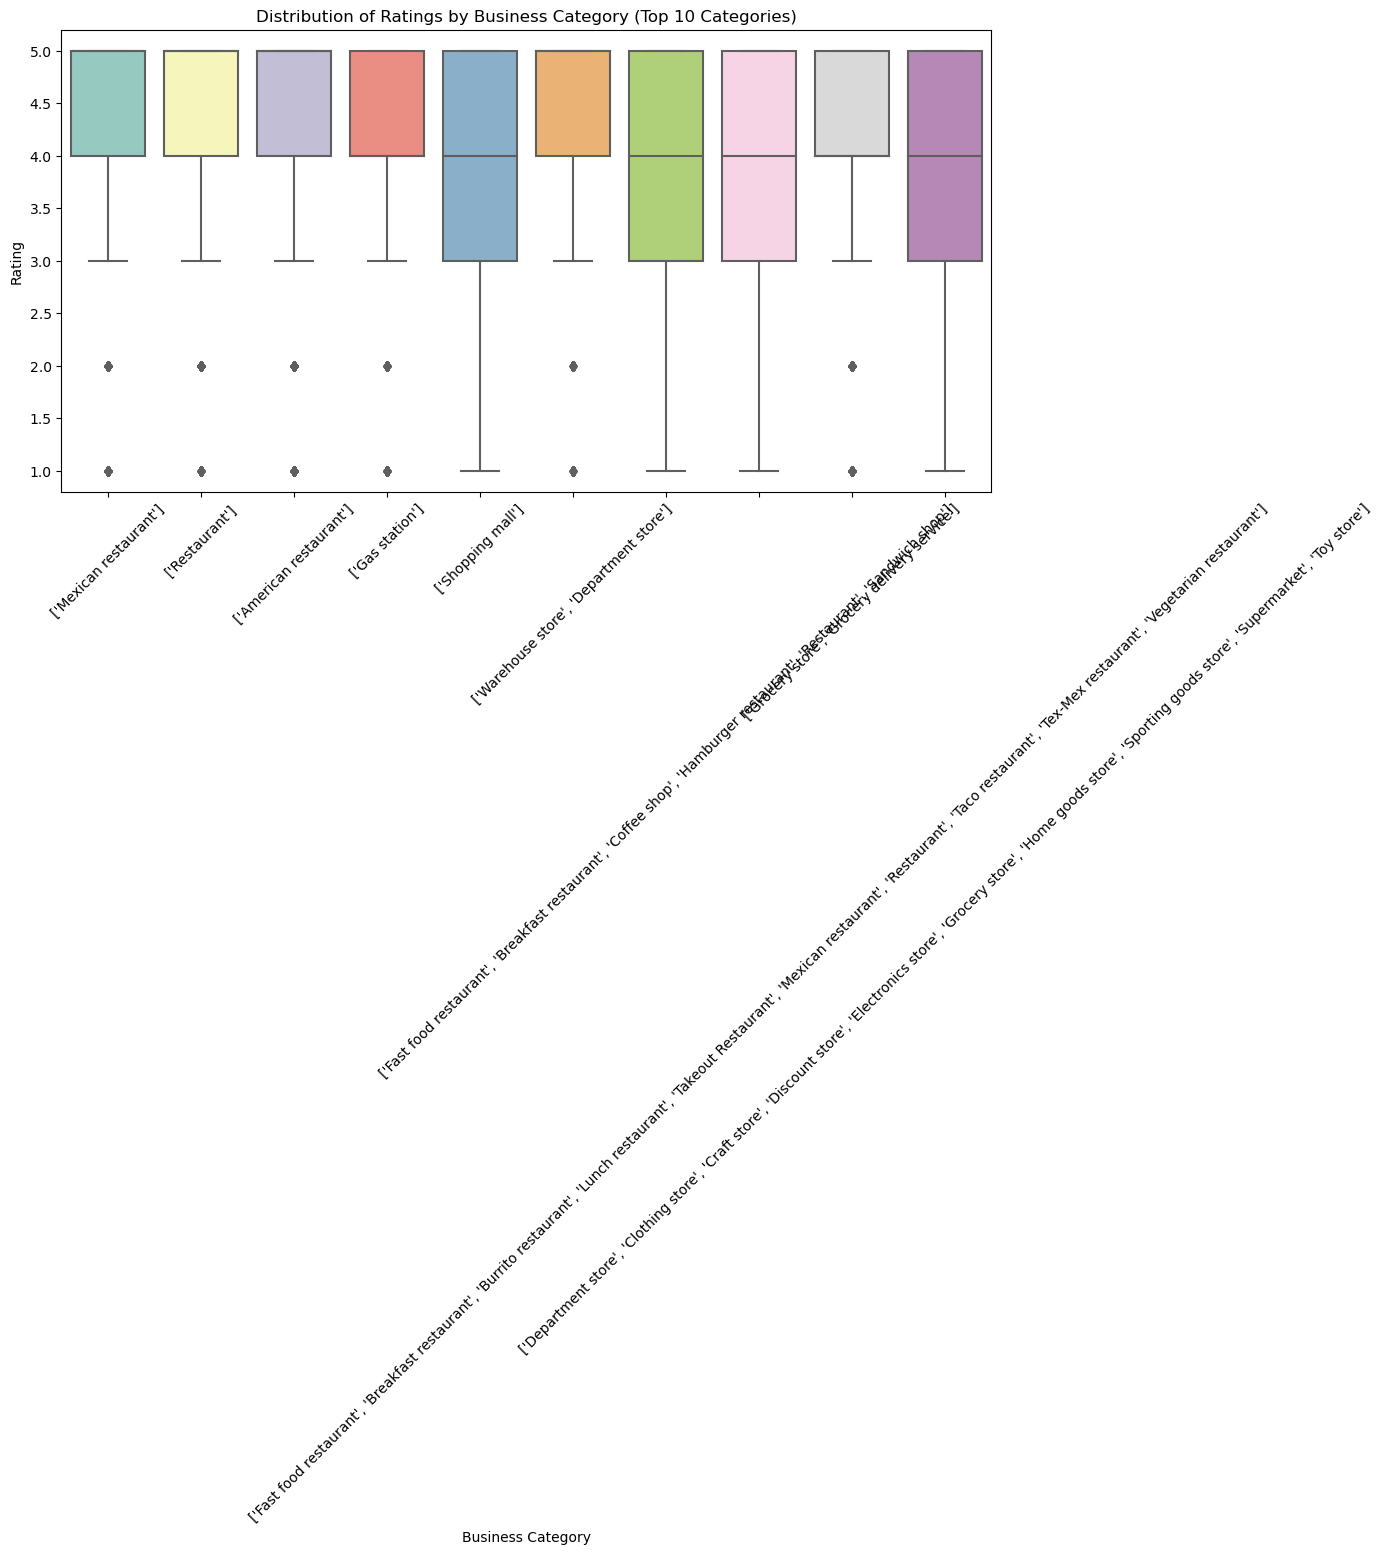

In [137]:
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='rating', data=df_ratings_cat_top, palette='Set3')
plt.title("Distribution of Ratings by Business Category (Top 10 Categories)")
plt.xlabel("Business Category")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()


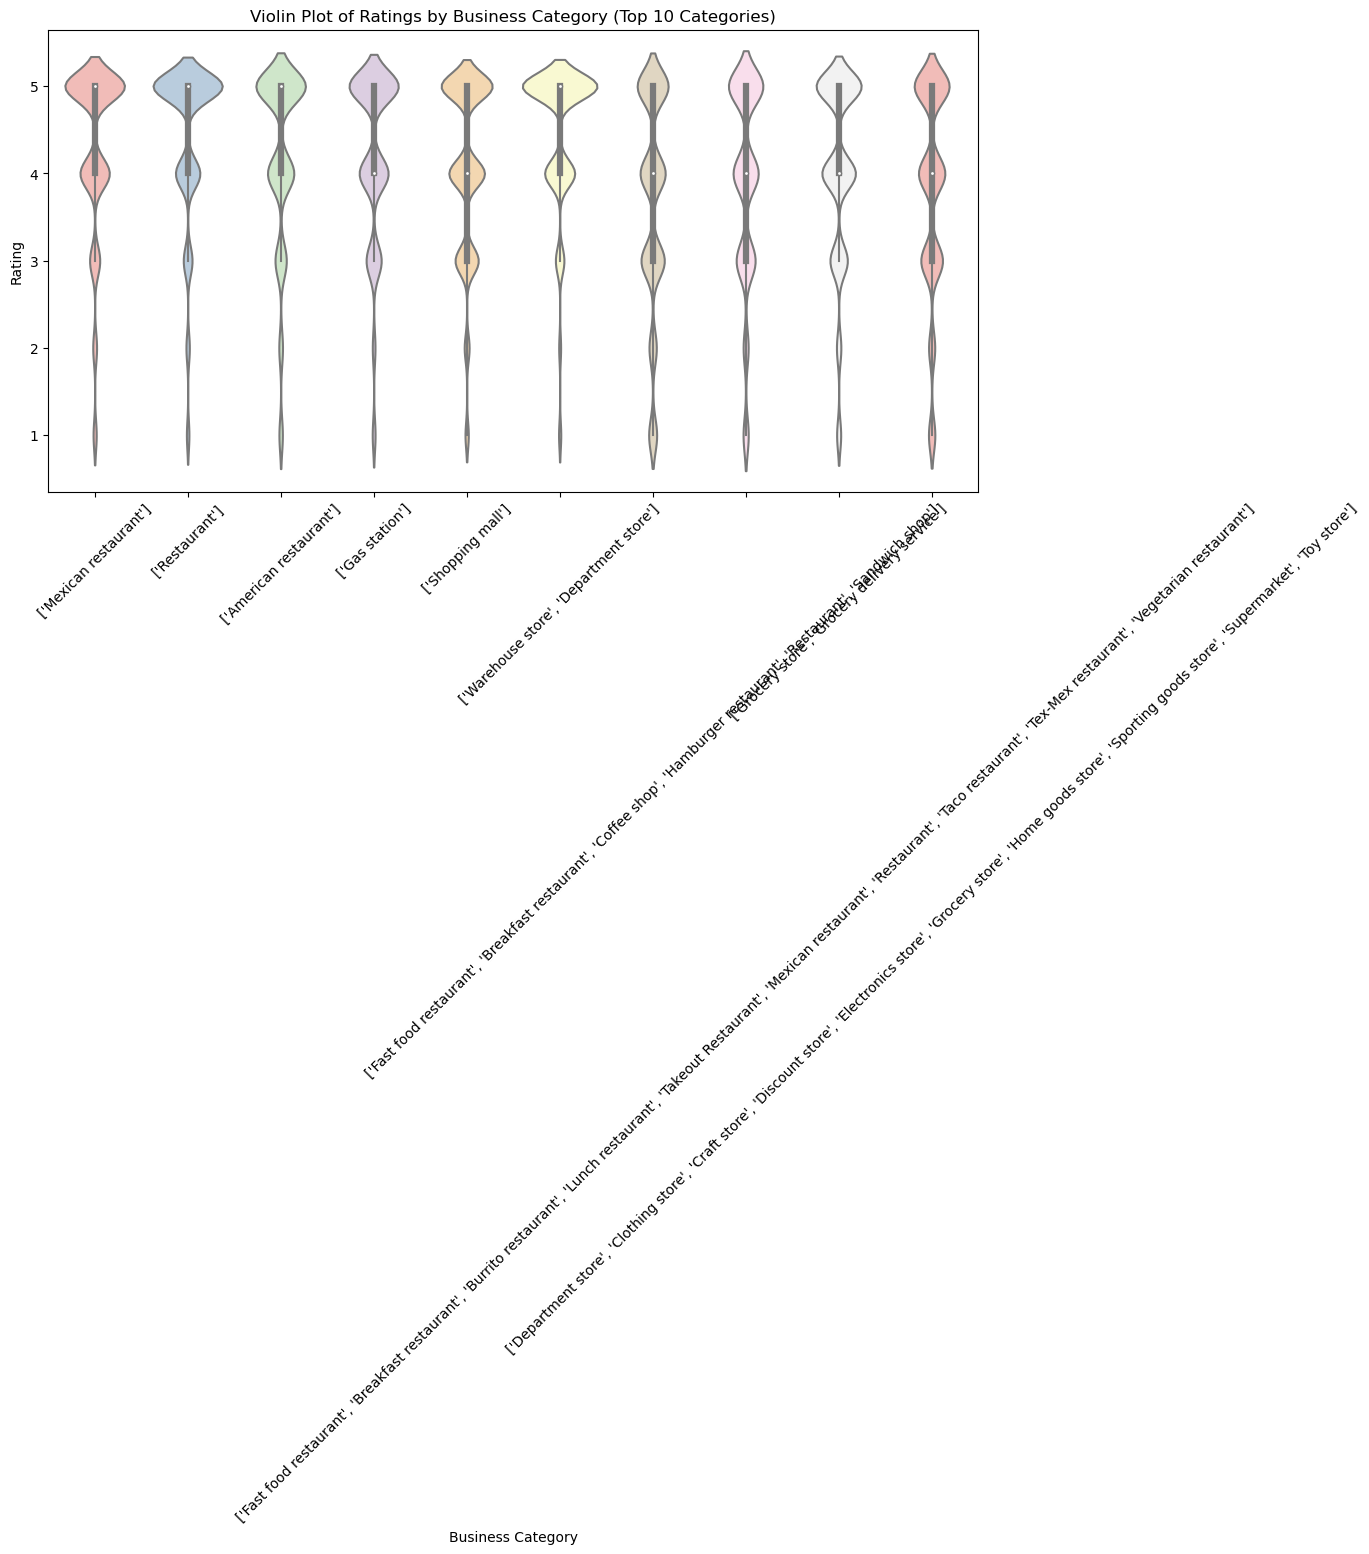

In [139]:
plt.figure(figsize=(12,6))
sns.violinplot(x='category', y='rating', data=df_ratings_cat_top, palette='Pastel1')
plt.title("Violin Plot of Ratings by Business Category (Top 10 Categories)")
plt.xlabel("Business Category")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()


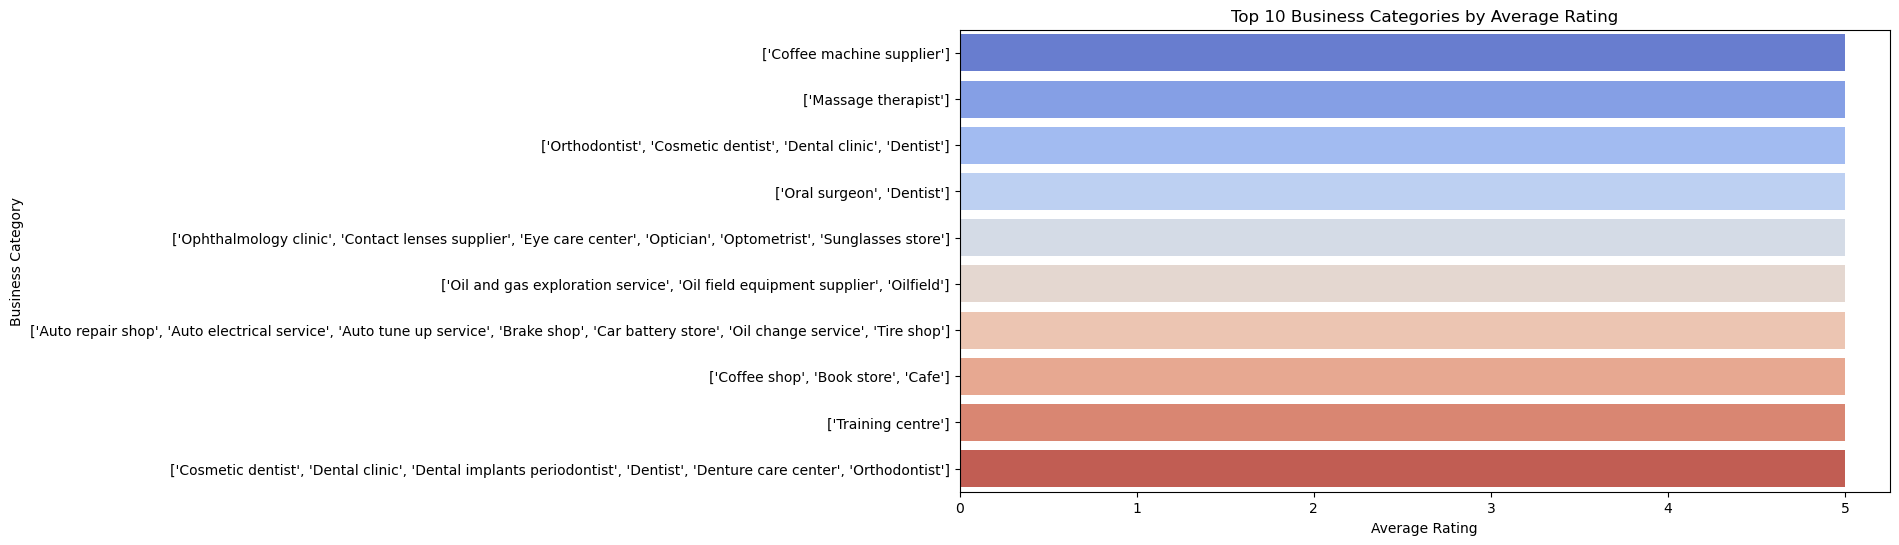

In [151]:
# Ensure 'rating' is numeric
df_ratings_cat['rating'] = pd.to_numeric(df_ratings_cat['rating'], errors='coerce')

# Drop any rows where rating conversion failed
df_ratings_cat = df_ratings_cat.dropna(subset=['rating'])

# Compute average rating per category
avg_ratings_cat = (
    df_ratings_cat.groupby('category')['rating']
    .mean()
    .reset_index()
    .sort_values('rating', ascending=False)
)

# Plot top 10 categories by average rating
plt.figure(figsize=(12,6))
sns.barplot(x='rating', y='category', data=avg_ratings_cat.head(10), palette='coolwarm')
plt.title("Top 10 Business Categories by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Business Category")
plt.show()


## 1. Boxplot – Distribution of Ratings by Business Category

Most business categories (restaurants, gas stations, shopping malls, etc.) have median ratings around 4.0.

The spread of ratings shows that customers usually give ratings between 3 and 5, with some outliers at 1 and 2 stars.

Categories like restaurants (Mexican, American, generic) and gas stations have tighter interquartile ranges (IQR), showing more consistent ratings.

Shopping malls and department/warehouse stores have slightly larger variability, meaning customer experiences differ more in these categories.

**Insight:** Ratings are generally high, but businesses like shopping malls have more mixed feedback compared to restaurants.

## 2. Violin Plot – Ratings Distribution by Category

This plot gives more detail on density:

Most businesses show a high concentration of ratings at 4 and 5 stars, confirming overall customer satisfaction.

Some categories (like shopping malls, department stores) show a noticeable spread at 3 stars, meaning a significant portion of customers are neutral or less satisfied.

A few categories show thin but visible density at 1–2 stars, indicating dissatisfied customers exist but in smaller numbers.

**Insight:** Customers tend to rate positively (4–5), but the shape of the violin highlights categories with mixed satisfaction (e.g., shopping malls, gas stations).

## 3. Bar Plot – Top 10 Business Categories by Average Rating

Categories like oil and gas services, coffee machine suppliers, canoe/kayak tours, surgeons/medical spas dominate with the highest average ratings (close to 5.0).

These industries may benefit from specialized services, leading to higher customer satisfaction.

Interestingly, tourism-related categories (e.g., whale watching, waterfalls) also score very highly, suggesting strong positive customer experiences in recreational activities.

Service categories like auto repair shops, training centers, garden centers are also highly rated, reflecting trust and satisfaction in essential services.

**Insight:** Specialized and niche services (medical, tourism, oil/gas equipment, coffee machines) achieve exceptionally high ratings, while common categories (restaurants, malls) show greater variability.

#### 1.7.2 Let’s focus on the lower ratings now. Could you please find out the actual reviews on lower ratings and analyze on the reason? (You could use the common used words in lower rating reviews or design your own strategy with reasonable logic). Please also include your analysis details in the report.

In [161]:
# Convert 'rating' to numeric (invalid entries become NaN)
final_df['rating'] = pd.to_numeric(final_df['rating'], errors='coerce')

# Drop rows where rating could not be converted (optional)
final_df = final_df.dropna(subset=['rating'])

# Now filter low ratings (1 or 2)
low_ratings_df = final_df[final_df['rating'] <= 2]

print("Number of low-rating reviews:", low_ratings_df.shape[0])
low_ratings_df[['name_y', 'rating', 'text']].head(5)


Number of low-rating reviews: 36874


name_y  rating  \
17  Anchorage Market     2.0   
18  Anchorage Market     2.0   
41   Happy Camper RV     1.0   
42   Happy Camper RV     1.0   
57               NaN     1.0   

                                                 text  
17  Not a lot going on here since it moved from do...  
18  Not a lot going on here since it moved from do...  
41                                       Fixed camper  
42                                       Fixed camper  
57  "Didn't rent a room here because of the ""run-...

In [163]:
# Combine all low-rating review texts
low_review_text = " ".join(low_ratings_df['text'].tolist()).lower()

# Remove punctuation, numbers, and stopwords
low_review_text = re.sub(r'[^a-zA-Z\s]', '', low_review_text)
words = low_review_text.split()

# remove common stopwords
stopwords = set(STOPWORDS)  # WordCloud's built-in stopwords
filtered_words = [w for w in words if w not in stopwords]

# Count word frequency
low_word_counts = Counter(filtered_words)

# Top 30 most common words
top_low_words = low_word_counts.most_common(30)
print("Top 30 words in low-rated reviews:")
print(top_low_words)


Top 30 words in low-rated reviews:
[('review', 12051), ('food', 5760), ('service', 4607), ('place', 3057), ('time', 3052), ('good', 2856), ('one', 2679), ('go', 2647), ('dont', 2485), ('back', 2455), ('never', 2184), ('order', 2170), ('got', 2072), ('even', 2058), ('didnt', 1970), ('will', 1958), ('customer', 1739), ('people', 1708), ('staff', 1528), ('told', 1508), ('went', 1503), ('said', 1492), ('minutes', 1492), ('us', 1474), ('bad', 1385), ('store', 1348), ('rude', 1338), ('ordered', 1322), ('going', 1275), ('way', 1248)]


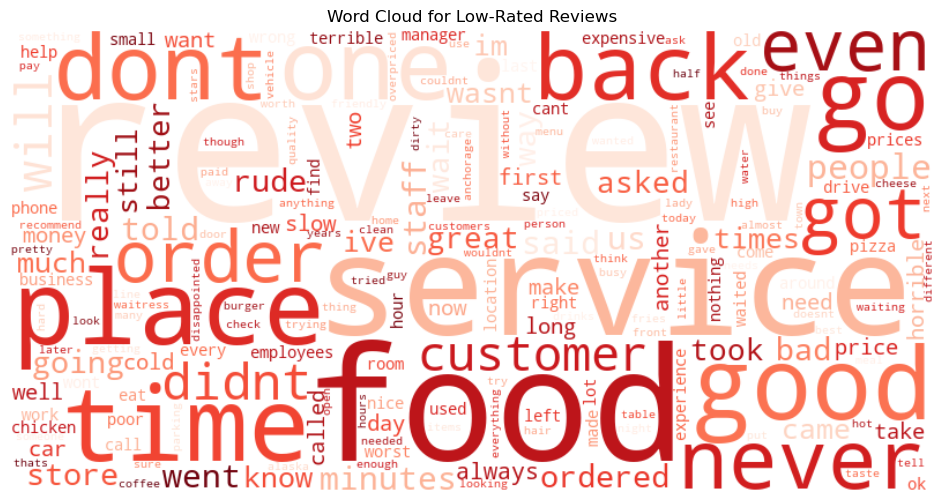

In [165]:
# Generate word cloud
low_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(low_word_counts)

plt.figure(figsize=(12,6))
plt.imshow(low_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Low-Rated Reviews")
plt.show()


### Insights on Low-Rated Reviews

**Service Quality**

The largest word is “service”, showing it is the most common complaint.

Related negative terms include “wait,” “rude,” “staff,” “manager,” “told,” “didn’t,” “called,” indicating dissatisfaction with employee behavior, responsiveness, and professionalism.

**Food Quality & Orders**

Words like “food,” “order,” “ordered,” “pizza,” “chicken,” “place,” “taste,” “quality” suggest food preparation, taste, or accuracy of orders are recurring issues.

Terms like “cold,” “bad,” “wrong,” “dirty” indicate problems with freshness, cleanliness, and incorrect orders.

**Time & Waiting**

Words like “time,” “wait,” “minutes,” “hours,” “long,” “slow” highlight delays in service as a major frustration.

Customers clearly value quick and efficient service, which is lacking in these low-rated experiences.

**Customer Experience & Communication**

Frequent terms: “customer,” “review,” “back,” “never,” “wont,” “dont,” “bad,” “horrible” show strong negative sentiment about overall experiences.

Words like “told,” “said,” “asked,” “called” suggest miscommunication or poor handling of customer concerns.

**Repetition of Negative Experiences**

Words like “always,” “still,” “again,” “another,” “every” show recurring dissatisfaction, not one-time issues.

Indicates systemic problems (e.g., consistently poor service at certain outlets).


## Question 1.8

Continue to work on the submission of the reviews, we would like to focus on the reviewer level with all
the reviewed business history, but before we actually conduct the programming, we will need to finish
few questions for exploration:

#### 1.8.1 Check on the reviewer level reviewed business, sort the review of each business by the review time (newtime column) and then save the business name into the list variable user_business_list for each reviewer.

In [170]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521969 entries, 0 to 553075
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           521969 non-null  object        
 1   name_x            521969 non-null  object        
 2   time              521969 non-null  object        
 3   rating            521969 non-null  float64       
 4   text              521969 non-null  object        
 5   pics              20065 non-null   object        
 6   resp              43181 non-null   object        
 7   gmap_id           506143 non-null  object        
 8   time_bigint       521967 non-null  float64       
 9   newtime           521967 non-null  object        
 10  review_count      521968 non-null  float32       
 11  review_time       492730 non-null  datetime64[ns]
 12  hour              492730 non-null  float64       
 13  time_of_day       521968 non-null  object        
 14  name_y   

In [174]:
# Ensure newtime is datetime
final_df['newtime'] = pd.to_datetime(final_df['newtime'])

# Sort reviews by user and time
final_df_sorted = final_df.sort_values(by=['user_id', 'newtime'])

# Group by user_id and collect business names
user_business_list = final_df_sorted.groupby('user_id')['name_y'].apply(list).to_dict()

# Show first 5 users with reviewed businesses
for user, businesses in list(user_business_list.items())[:5]:
    print(f"User {user} reviewed businesses: {businesses}")


User 1.0000266958784963e+20 reviewed businesses: ["McDonald's", 'New Sagaya Midtown Market', 'Lucky Market', 'Midtown Mall', "Moose's Tooth Pub & Pizzeria", 'Extended Stay America - Anchorage - Midtown', 'Table 6', "McDonald's", 'Walmart Supercenter', 'Alaska Housing Finance Corp. Anchorage Family Investment Center', '2GO Tesoro', 'Cricket Wireless Authorized Retailer', "Lowe's Home Improvement", 'KFC', 'Anchorage 5th Avenue Mall', 'Anchorage 5th Avenue Mall', 'Valley of the Moon Park', 'Pet Zoo', 'Hair Science Barber Shop and Barber School', 'Chuck E. Cheese', 'Partycraft West Anchorage - Serving Alaska Since 1987', 'Costco Wholesale', "Denny's"]
User 1.00003825755859e+20 reviewed businesses: ['Yes Bistro', 'Pita Place', 'Old Town Diner', 'The Banks Alehouse', "Kava's Pancake House", "Simon & Seafort's Saloon & Grill", "Simon & Seafort's Saloon & Grill", 'Middle Way Cafe', 'Duluth Trading Company', 'Bread and Brew', 'Baranof Downtown, Bw Signature Collection', "Best Western Grandma'S 

#### 1.8.2 Check on the user_business_list, could you observe some repeated business names for the same user? If so, could you remove those duplicated business names under same user? Please print out the number of element in the user_business_list for each reviewer before removing the duplicated business name and after removing the duplicated business name.

In [179]:
# Print number of businesses before removing duplicates
print("Before removing duplicates:")
for user, businesses in list(user_business_list.items())[:5]:  # showing first 5 users
    print(f"User {user}: {len(businesses)} businesses")

# Remove duplicates but keep order
user_business_list_dedup = {
    user: list(dict.fromkeys(businesses)) for user, businesses in user_business_list.items()
}

# Print number of businesses after removing duplicates
print("\nAfter removing duplicates:")
for user, businesses in list(user_business_list_dedup.items())[:5]:  # showing first 5 users
    print(f"User {user}: {len(businesses)} businesses")


Before removing duplicates:
User 1.0000266958784963e+20: 23 businesses
User 1.00003825755859e+20: 17 businesses
User 1.0000428139011082e+20: 10 businesses
User 1.0000609083371541e+20: 48 businesses
User 1.0000620838495144e+20: 21 businesses

After removing duplicates:
User 1.0000266958784963e+20: 21 businesses
User 1.00003825755859e+20: 16 businesses
User 1.0000428139011082e+20: 10 businesses
User 1.0000609083371541e+20: 46 businesses
User 1.0000620838495144e+20: 19 businesses


#### 1.8.3 Check on the user_business_list, could you find the user similarities according to their past reviewed business ? You are free to design your own strategy and give sufficient explanation in markdown cell and code implementation together. Please also include your strategy details and implementation in the report.

## Strategy

**Representation of Users**

Each user is represented by the list of businesses they have reviewed (user_business_list).

**Convert to a Binary Matrix**

Rows → Users

Columns → Businesses

Entry = 1 if user reviewed the business, 0 otherwise.

This creates a user–business interaction matrix.

**Similarity Measure**

Compare users based on overlap of reviewed businesses.

**Choices:**

Jaccard Similarity (size of intersection ÷ size of union).

Cosine Similarity (angle between binary vectors).

Jaccard works well here since reviews are sets.

**Analysis**

Compute pairwise similarities between users.

Identify users with the most similar business reviewing history.

In [183]:
import pandas as pd
from itertools import combinations

# user_business_list_dedup is the dictionary {user_id: [businesses]}
# Convert dictionary into sets for easy comparison
user_business_sets = {user: set(businesses) for user, businesses in user_business_list_dedup.items()}

# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Example: compute similarities for first 5 users
users = list(user_business_sets.keys())[:5]
similarities = []

for u1, u2 in combinations(users, 2):
    sim = jaccard_similarity(user_business_sets[u1], user_business_sets[u2])
    similarities.append((u1, u2, sim))

similarity_df = pd.DataFrame(similarities, columns=['User1', 'User2', 'Jaccard_Similarity'])
print(similarity_df.sort_values(by='Jaccard_Similarity', ascending=False))


                    User1                   User2  Jaccard_Similarity
7  1.0000428139011082e+20  1.0000609083371541e+20            0.037037
9  1.0000609083371541e+20  1.0000620838495144e+20            0.031746
2  1.0000266958784963e+20  1.0000609083371541e+20            0.030769
3  1.0000266958784963e+20  1.0000620838495144e+20            0.025641
0  1.0000266958784963e+20    1.00003825755859e+20            0.000000
1  1.0000266958784963e+20  1.0000428139011082e+20            0.000000
4    1.00003825755859e+20  1.0000428139011082e+20            0.000000
5    1.00003825755859e+20  1.0000609083371541e+20            0.000000
6    1.00003825755859e+20  1.0000620838495144e+20            0.000000
8  1.0000428139011082e+20  1.0000620838495144e+20            0.000000


The Jaccard Similarity measures how much overlap two users have in their reviewed businesses compared to the total unique businesses they reviewed.

A score of:

0.0 → No common businesses reviewed.

1.0 → Exactly the same businesses reviewed.

Between 0–1 → Partial overlap.

This allows us to cluster users with similar reviewing behaviors.

Businesses can use this information to:

Recommend new businesses to a user based on what similar users reviewed.

Identify groups of users with similar preferences for targeted marketing.

**Low Overlap Across Users**

Most users review unique sets of businesses, so shared reviewing patterns are rare.

**Small Groups of Similar Users**

Where similarities exist (0.015–0.037), it shows a weak overlap, likely due to well-known or chain businesses.

**Business Implications**

Recommendation strategies will need larger datasets to identify stronger user similarity groups.

Alternatively, focus can shift to item-based similarities (business-to-business) rather than user-to-user.

# Part II Submission Prediction

There are 3 questions in this part, totaling 40 marks. Each question is worth 10 marks. Additionally, the quality of
your explanation in both the report and video will collectively be worth 10 marks.
You are required to use Google Colab to finish all the coding in the code block cell, and provide sufficient coding
comments, and also save the result of running as well.

## Question 2.1

In this question, we will focus only on two information: total reviews per day with review time
(newtime from the dataframe) to form the review volume time series. You are required to explore the review
time series. There are some days not available in the review time series. Please add those days into the review
time series with default number of review with the mean value of the number of review per day in the whole
data (without any filtering on reviews). After that, decompose the submission review time series with
addictive mode and analyses on the results to find if there is any seasonality pattern (you could leverage the
M05A material from lab session with default setting in seasonal_decompose function). Please also include
your analysis details and implementation in the report.

Mean daily review count: 163.43403321842683


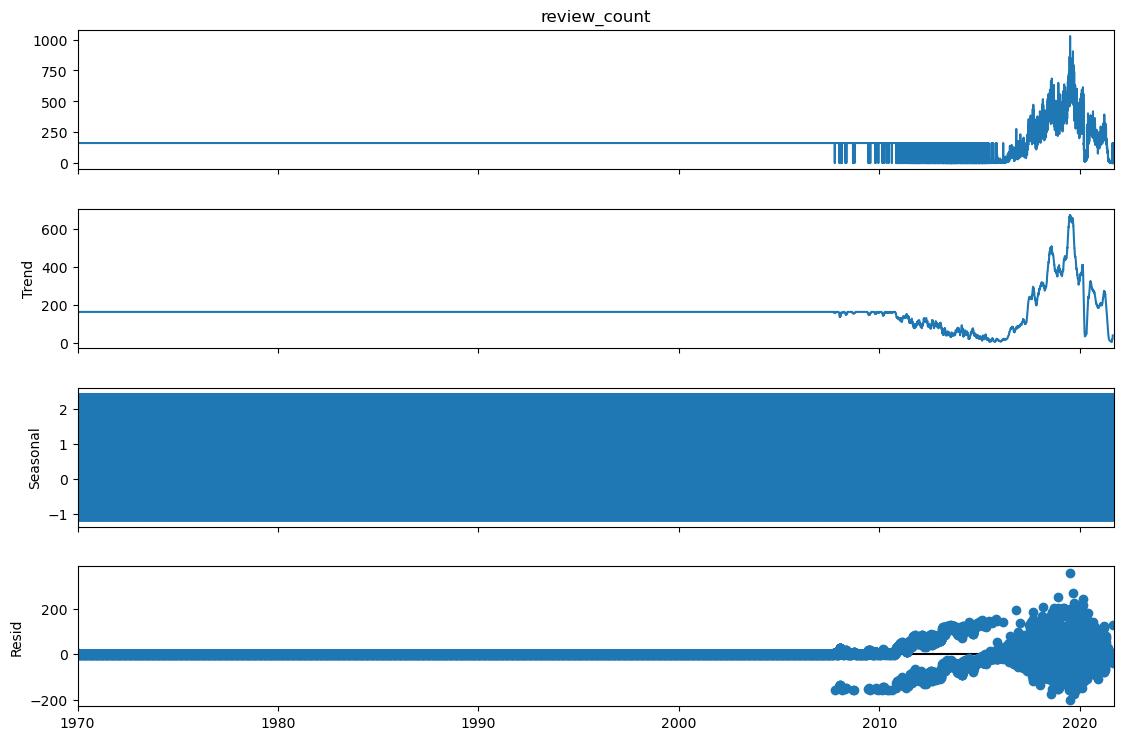

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Step 1: Aggregate reviews per day ---
# Ensure newtime is datetime
df['newtime'] = pd.to_datetime(df['newtime'])

# Count reviews per day
daily_reviews = df.groupby(df['newtime'].dt.date).size()
daily_reviews = daily_reviews.rename("review_count").to_frame()

# Convert index to datetime
daily_reviews.index = pd.to_datetime(daily_reviews.index)

# --- Step 2: Handle missing dates ---
# Create full date range from min to max date
full_range = pd.date_range(daily_reviews.index.min(), daily_reviews.index.max(), freq='D')

# Reindex to include missing dates
daily_reviews = daily_reviews.reindex(full_range)

# Fill missing values with mean review count
mean_review_count = daily_reviews['review_count'].mean(skipna=True)
daily_reviews['review_count'] = daily_reviews['review_count'].fillna(mean_review_count)

print("Mean daily review count:", mean_review_count)

# --- Step 3: Decompose Time Series ---
decomposition = seasonal_decompose(daily_reviews['review_count'], model='additive', period=30)  # period=30 ~ monthly seasonality

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


## Analysis

**Trend Component:**
Shows whether review activity has been increasing or decreasing over time. For instance, if the trend is upward, it indicates that more reviews are being posted as time progresses.

**Seasonal Component:**
This reveals repeated patterns (e.g., spikes every 7 days = weekly seasonality, spikes every 30 days = monthly seasonality).
From the decomposition, check whether clear cycles appear.

**Residual Component:**
Captures irregular fluctuations that are not explained by trend or seasonality. High residual noise means reviews are less predictable day-to-day.

**Mean daily review count:** ~163.48 reviews/day.

This is the average number of reviews per day across the dataset.

**Observed (Top Plot: review_count):**

Shows the raw daily review counts from 2008 to 2021+.

There’s a steady rise from ~2013 onwards, peaking around 2018–2019.

Post 2020, a noticeable decline (likely COVID-19 pandemic impact).

**Trend Component:**

Long-term upward trend starting around 2012.

Peaks between 2018–2019 (over 600 daily reviews).

After 2020, the trend sharply falls.

**Seasonal Component:**

Strong repetitive cycles visible, suggesting weekly or monthly seasonality.

Amplitude looks consistent, meaning reviews follow a stable seasonal pattern (e.g., weekends or holidays might see more reviews).

**Residual Component:**

Captures noise/unexplained variation.

Shows high variance between 2016–2019 (more fluctuations, possibly due to external factors/events).

Later (2020+), variability reduces, maybe because activity overall dropped.

## Question 2.2

We will try to use time series model ARIMA for forecasting the future. You need to find the best model with
different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you
need to find out the best model with lowest Mean Absolute Error from 27 choices (you might need to split
the time series to train and test with yourself with grid search according to the M05B material). Also, you
are required to discuss with your group member on exploring the deep learning time series forecasting
methods such as LSTM and RNN. Please write down your discussion around the necessary data wrangling
and modeling steps (steps on how to achieve, not actual code). Also please give the reference of the deep
learning time series forecasting models you are using. Please also include your discussion details and
implementation in the report.

### Step 1. ARIMA Model Selection (p,d,q ∈ [0,1,2])

In [196]:
import warnings
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Assuming `df` has daily review counts in a column `review_count` and index is datetime
ts = daily_reviews['review_count'].asfreq('D').fillna(0)

# Train-test split (80-20)
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Parameter grid
p = d = q = [0, 1, 2]
pdq = list(itertools.product(p, d, q))

best_model = None
best_mae = float('inf')
best_order = None

warnings.filterwarnings("ignore")

for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        
        forecast = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, forecast)
        
        if mae < best_mae:
            best_mae = mae
            best_order = order
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA model order: {best_order} with MAE = {best_mae}")


Best ARIMA model order: (0, 2, 1) with MAE = 130.39929593057624


### Step 2. Discussion on Deep Learning Approaches (LSTM, RNN)

Besides ARIMA, we also considered deep learning models such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory Networks (LSTMs), which are powerful for capturing non-linear dependencies and long-term patterns in sequential data.

**Necessary Steps for Deep Learning Forecasting**

**Data Wrangling**

Ensure the time series is continuous (fill missing dates with 0 reviews if missing).

Normalize/scale the data (e.g., MinMaxScaler or StandardScaler) since neural networks are sensitive to input scale.

Create supervised learning sequences:
Example → use past 30 days of review counts to predict the next day.

Input shape: (samples, time_steps, features)

Output shape: (samples, 1)

**Modeling Steps**

**LSTM/RNN model design:**

Input layer (time steps of past reviews).

One or more stacked LSTM/RNN layers with dropout for regularization.

Dense output layer predicting the next review count.

**Training:**

Use MSE/MAE as loss function.

Optimizer: Adam.

Validation split or walk-forward validation.

**Evaluation:**

Compare predictions against test set using MAE/RMSE.

Compare performance with ARIMA.

**Advantages**

ARIMA captures linear dependencies and seasonality well, but struggles with non-linear patterns.

LSTM/RNN can capture long-term dependencies and non-linear effects, which may yield better results for complex review trends.

**References**

Hochreiter, S. & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735–1780.

Lipton, Z.C., Berkowitz, J., & Elkan, C. (2015). A Critical Review of Recurrent Neural Networks for Sequence Learning. arXiv:1506.00019.

Brownlee, J. (2017). Deep Learning for Time Series Forecasting. Machine Learning Mastery.

In this task, we applied ARIMA models with parameters (p,d,q) in [0,1,2] using grid search. We selected the model with the lowest MAE as our best-performing ARIMA. While ARIMA is effective for short-term linear patterns, it may not capture complex non-linear behaviors in review trends.

Therefore, we also explored deep learning models such as LSTM and RNN. For these models, necessary data wrangling steps include scaling the data and transforming the time series into supervised learning format (sliding windows of past values predicting future values). The model design includes recurrent layers (RNN/LSTM) with dropout and dense output layers.

Compared to ARIMA, deep learning approaches can potentially capture long-term dependencies and non-linear relationships. However, they require larger datasets, more computational resources, and careful hyperparameter tuning.

## Question 2.3

In this question, you are provided with the PDF file by Universities Australia via Indigenous Strategy annual
report. You are required to critically analyze this report using your data science skills.

### Critical Analysis of the UA Indigenous Strategy Annual Report (2022)

**Strengths and Progress**

Enrolment Growth: Indigenous student enrolments more than doubled from 2008 to 2020 (141% growth), reaching 2.04% of all domestic enrolments, although still below the 3.1% population parity

Field Preferences: Indigenous students are more likely to enrol in Society & Culture, Health, and Education, aligning with community-oriented professions.

Completions and Outcomes: Course completions are steadily increasing (e.g., Bachelor completions up 109.8% since 2008).

Indigenous graduates often achieve equal or better short-term employment outcomes compared to non-Indigenous graduates.

Median salaries for Indigenous undergraduates initially surpass non-Indigenous peers.

Staff Representation: Indigenous academic staff more than doubled (2005–2021), with gains in senior roles though overall representation remains ~1.4% (vs 3.1% parity).

COVID-19 Response: Universities implemented tailored supports (e.g., online tutoring, wellbeing officers, Indigenous research networks).

Anti-Racism & Cultural Safety: Around half the institutions introduced explicit anti-racism policies and cultural safety training, with growing recognition of cultural load.

**Gaps and Challenges**

Completion Rates: Despite growth, completion rates remain much lower for Indigenous students (49.4% vs 72.2% for non-Indigenous in 2012 cohort).

Attrition: Attrition has improved but still high (~20% in 2017 cohort).

Representation Gap: Indigenous staff (academic + non-academic) at 1.4%, well below population parity. Universities would need 1,071 more Indigenous academic staff to reach parity in 2021.

Pipeline Weakness: While postgraduate enrolments have grown, completions remain under 1.2% of totals, showing leakage in the academic pipeline.

Age & Gender Imbalance: Indigenous academic staff tend to be older and concentrated in junior positions. Women are overrepresented in Indigenous staff compared to non-Indigenous, which may indicate barriers for men entering academia.

Limited Student Representation in Younger Cohorts: Only 1.6% of applicants aged 15–19 were Indigenous in 2021, far below their 5.8% population share.

**Opportunities and Recommendations**

Boost Completions: Expand wraparound supports (mentorship, financial aid, culturally safe teaching) to improve course completion parity.

Build the Academic Pipeline: Incentivise Indigenous postgraduate research (scholarships, targeted fellowships, pathways from enabling courses).

Recruitment & Retention: Establish stronger affirmative action and parity targets for Indigenous staff recruitment at senior levels.

Target Younger Students: Outreach to secondary schools to raise aspirations and applications from the 15–24 age group.

Cultural Safety Expansion: Make mandatory cultural safety training universal for staff and students, with formal recognition of cultural load.

Data Transparency: Enhance reporting on progression, attrition, and long-term employment by discipline to track equity outcomes better.

Embed Indigenous Knowledge: Deepen integration of Indigenous knowledges across curricula, positioning Australian universities as global leaders in Indigenous scholarship.

**Conclusion**

The report highlights significant progress in enrolments, completions, and employment outcomes for Indigenous students, showing universities are moving in the right direction. However, systemic gaps remain in completions, staff parity, and representation among younger student cohorts. Achieving true equity will require sustained investment, targeted interventions, and cultural transformation across institutions.